# Assignment 2
#### Authors: Lucas Schmidt Ferreira de Araujo

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

sns.set_style("whitegrid")
sns.set_palette("rocket")
warnings.filterwarnings("ignore")

# European Option Price based on Black-Scholes Formula

In [3]:
class EuropeanCall:
    def __init__(self, K, r, sigma, T):
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T

    def payoff(self, S):
        return np.maximum(S - self.K, 0)

    def price(self, S, t):
        d1 = (np.log(S / self.K) + (self.r + self.sigma**2 / 2) * (self.T - t)) / (self.sigma * np.sqrt(self.T - t))
        d2 = d1 - self.sigma * np.sqrt((self.T - t))
        return S * norm.cdf(d1) - self.K * np.exp(-self.r * (self.T - t)) * norm.cdf(d2)

    def delta(self, S, t):
        d1 = (np.log(S / self.K) + (self.r + self.sigma**2 / 2) * (self.T - t)) / (self.sigma * np.sqrt(self.T - t))
        return norm.cdf(d1)

    def gamma(self, S, t):
        d1 = (np.log(S / self.K) + (self.r + self.sigma**2 / 2) * (self.T - t)) / (self.sigma * np.sqrt(self.T - t))
        return norm.pdf(d1) / (S * self.sigma * np.sqrt(self.T - t))


class EuropeanPut:
    def __init__(self, K, r, sigma, T):
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T

    def payoff(self, S):
        return np.maximum(self.K - S, 0)

    def price(self, S, t):
        d1 = (np.log(S / self.K) + (self.r + self.sigma**2 / 2) * (self.T - t)) / (self.sigma * np.sqrt(self.T - t))
        d2 = d1 - self.sigma * np.sqrt((self.T - t))
        return -S * norm.cdf(-d1) + self.K * np.exp(-self.r * (self.T - t)) * norm.cdf(-d2)

    def delta(self, S, t):
        d1 = (np.log(S / self.K) + (self.r + self.sigma**2 / 2) * (self.T - t)) / (self.sigma * np.sqrt(self.T - t))
        return norm.cdf(d1) - 1

    def gamma(self, S, t):
        d1 = (np.log(S / self.K) + (self.r + self.sigma**2 / 2) * (self.T - t)) / (self.sigma * np.sqrt(self.T - t))
        return norm.pdf(d1) / (S * self.sigma * np.sqrt(self.T - t))

# Binomial Trees

## Cox-Ross-Rubinstein (CRR) binomial tree model

The exact equations for the up ($u$) and down ($d$) multiplicative factors, and probability of an upward movement ($p$) in the Cox-Ross-Rubinstein (CRR) binomial model are given by
\begin{align*}
u &= \frac{\exp(- r \, \Delta t) + \exp\left((r + \sigma^2) \, \Delta t\right) + \sqrt{\left(\exp(-r \, \Delta t) + \exp\left((r + \sigma^2) \, \Delta t\right)\right)^2 - 4}}{2}, \\
d &= \frac{1}{u}, \\
p &= \frac{\exp(r \, \Delta t) - d}{u - d},
\end{align*}

where
- $r$ is the risk-free interest rate,
- $\sigma$ is the volatility of the underlying asset,
- $\Delta t$ is the length of each time step.

We can approximate it using 

\begin{align*}
u &= \exp(\sigma \sqrt{\Delta t}), \\
d &= \frac{1}{u} = \exp(-\sigma \sqrt{\Delta t}), \\
p &= \frac{\exp(r \, \Delta t) - d}{u - d}.
\end{align*}

In [4]:
def CRR_exact_European(S, K, T, r, sigma, N , call = True):
    """
    Calculates the price of a European call option using the Cox-Ross-Rubinstein (CRR) binomial tree model.

    Args:
        S: Current stock price.
        K: Strike price.
        T: Time to maturity (in years).
        r: Risk-free interest rate (annualized).
        sigma: Volatility of the underlying asset (annualized).
        N: Number of time steps in the binomial tree.

    Returns:
        The price of the European call option.
    """

    delta_t = T / N
    u = (np.exp(- r * delta_t) + np.exp((r+sigma**2)*delta_t) + np.sqrt((np.exp(-r*delta_t)+np.exp((r+sigma**2)*delta_t))**2-4)) / 2
    d = 1 / u
    p = (np.exp(r * delta_t) - d) / (u - d)

    if call:
        option_values = [max(0, S * (u**j) * (d**(N - j)) - K) for j in range(N + 1)]
    else:
        option_values = [max(0, K - S * (u**j) * (d**(N - j)) ) for j in range(N + 1)]
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_values[j] = np.exp(-r * delta_t) * (p * option_values[j + 1] + (1 - p) * option_values[j])
    return option_values[0]

def CRR_approx_European(S, K, T, r, sigma, N, call = True):
    """
    Calculates the price of a European call option using the Cox-Ross-Rubinstein (CRR) binomial tree model.

    Args:
        S: Current stock price.
        K: Strike price.
        T: Time to maturity (in years).
        r: Risk-free interest rate (annualized).
        sigma: Volatility of the underlying asset (annualized).
        N: Number of time steps in the binomial tree.

    Returns:
        The price of the European call option.
    """

    delta_t = T / N
    u = np.exp(sigma * np.sqrt(delta_t))
    d = 1 / u
    p = (np.exp(r * delta_t) - d) / (u - d)

    if call:
        option_values = [max(0, S * (u**j) * (d**(N - j)) - K) for j in range(N + 1)]
    else:
        option_values = [max(0, K - S * (u**j) * (d**(N - j)) ) for j in range(N + 1)]
    
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_values[j] = np.exp(-r * delta_t) * (p * option_values[j + 1] + (1 - p) * option_values[j])
    return option_values[0]


## Jarrow-Rudd (JR) binomial tree model

In the Jarrow-Rudd model the exact formulas are given by

\begin{align*}
u &= \exp(r \, \Delta t) \left(1 + \sqrt{\exp(\sigma^2 \, \Delta t) - 1}\right), \\
d &= \exp(r \, \Delta t) \left(1 - \sqrt{\exp(\sigma^2 \, \Delta t) - 1}\right), \\
p &= \frac{1}{2},
\end{align*}

and they can be approximated by

\begin{align*}
u &= \exp\left(\left(r - \frac{\sigma^2}{2}\right) \Delta t + \sigma \sqrt{\Delta t}\right), \\
d &= \exp\left(\left(r - \frac{\sigma^2}{2}\right) \Delta t - \sigma \sqrt{\Delta t}\right), \\
p &= \frac{1}{2}.
\end{align*}


In [5]:
def JR_exact_European(S, K, T, r, sigma, N, call = True):
    """
    Calculates the price of a European option using the exact Jarrow-Rudd (JR) binomial tree formula.

    Args:
        S (float): Current stock price.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        r (float): Risk-free interest rate (annualized).
        sigma (float): Volatility of the underlying asset (annualized).
        N (int): Number of time steps in the binomial tree.
        call (bool, optional): If True, calculates the price of a call option. 
                               If False, calculates the price of a put option. 
                               Defaults to True.

    Returns:
        (float): The calculated price of the European option (call or put).
    """

    delta_t = T / N
    u = np.exp(r*delta_t) * (1 + np.sqrt(np.exp(sigma**2 * delta_t)-1))
    d = np.exp(r*delta_t) * (1 - np.sqrt(np.exp(sigma**2 * delta_t)-1))
    p = 1/2

    if call:
        option_values = [max(0, S * (u**j) * (d**(N - j)) - K) for j in range(N + 1)]
    else:
        option_values = [max(0, K - S * (u**j) * (d**(N - j)) ) for j in range(N + 1)]

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_values[j] = np.exp(-r * delta_t) * (p * option_values[j + 1] + (1 - p) * option_values[j])
    return option_values[0]

def JR_approx_European(S, K, T, r, sigma, N, call = True):
    """
    Calculates the price of a European option using the an approximate Jarrow-Rudd (JR) binomial tree formula.

    Args:
        S (float): Current stock price.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        r (float): Risk-free interest rate (annualized).
        sigma (float): Volatility of the underlying asset (annualized).
        N (int): Number of time steps in the binomial tree.
        call (bool, optional): If True, calculates the price of a call option. 
                               If False, calculates the price of a put option. 
                               Defaults to True.

    Returns:
        (float): The calculated price of the European option (call or put).
    """

    delta_t = T / N
    u = np.exp((r-sigma**2/2)*delta_t + sigma*np.sqrt(delta_t))
    d = np.exp((r-sigma**2/2)*delta_t - sigma*np.sqrt(delta_t))
    p = 1/2

    if call:
        option_values = [max(0, S * (u**j) * (d**(N - j)) - K) for j in range(N + 1)]
    else:
        option_values = [max(0, K - S * (u**j) * (d**(N - j)) ) for j in range(N + 1)]

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_values[j] = np.exp(-r * delta_t) * (p * option_values[j + 1] + (1 - p) * option_values[j])
    return option_values[0]

## Binomial Trees for American Options

In [6]:
def CRR_exact_American(S, K, T, r, sigma, N, call = True):
    """
    Calculates the price of an American call option using the Cox-Ross-Rubinstein (CRR) binomial tree model.

    Args:
        S (float): Current stock price.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        r (float): Risk-free interest rate (annualized).
        sigma (float): Volatility of the underlying asset (annualized).
        N (int): Number of time steps in the binomial tree.

    Returns:
        float: The price of the American call option.
    """
    delta_t = T / N
    u = (np.exp(- r * delta_t) + np.exp((r+sigma**2)*delta_t) + np.sqrt((np.exp(-r*delta_t)+np.exp((r+sigma**2)*delta_t))**2-4)) / 2
    d = 1 / u
    p = (np.exp(r * delta_t) - d) / (u - d)

    if call:
        option_values = [max(0, S * (u**j) * (d**(N - j)) - K) for j in range(N + 1)]
    else:
        option_values = [max(0, K - S * (u**j) * (d**(N - j)) ) for j in range(N + 1)]

    # Backward induction to calculate option price at t = 0
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            continuation_value = np.exp(-r * delta_t) * (p * option_values[j + 1] + (1 - p) * option_values[j])
            if call:
                intrinsic_value = max(0, S * (u**j) * (d**(i - j)) - K)
            else:
                intrinsic_value = max(0, K - S * (u**j) * (d**(i - j)) )
            option_values[j] = max(continuation_value, intrinsic_value)
    return option_values[0]

def CRR_approx_American(S, K, T, r, sigma, N, call = True):
    """
    Calculates the price of an American call option using the Cox-Ross-Rubinstein (CRR) binomial tree model.

    Args:
        S (float): Current stock price.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        r (float): Risk-free interest rate (annualized).
        sigma (float): Volatility of the underlying asset (annualized).
        N (int): Number of time steps in the binomial tree.

    Returns:
        float: The price of the American call option.
    """
    delta_t = T / N
    u = np.exp(sigma * np.sqrt(delta_t))
    d = 1 / u
    p = (np.exp(r * delta_t) - d) / (u - d)

    if call:
        option_values = [max(0, S * (u**j) * (d**(N - j)) - K) for j in range(N + 1)]
    else:
        option_values = [max(0, K - S * (u**j) * (d**(N - j)) ) for j in range(N + 1)]

    # Backward induction to calculate option price at t = 0
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            continuation_value = np.exp(-r * delta_t) * (p * option_values[j + 1] + (1 - p) * option_values[j])
            if call:
                intrinsic_value = max(0, S * (u**j) * (d**(i - j)) - K)
            else:
                intrinsic_value = max(0, K - S * (u**j) * (d**(i - j)) )
            option_values[j] = max(continuation_value, intrinsic_value)
    return option_values[0]

In [7]:
def JR_exact_American(S, K, T, r, sigma, N , call = True):
    """
    Calculates the price of an American call option using the Cox-Ross-Rubinstein (CRR) binomial tree model.

    Args:
        S (float): Current stock price.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        r (float): Risk-free interest rate (annualized).
        sigma (float): Volatility of the underlying asset (annualized).
        N (int): Number of time steps in the binomial tree.

    Returns:
        float: The price of the American call option.
    """
    delta_t = T / N
    u = np.exp(r*delta_t) * (1 + np.sqrt(np.exp(sigma**2 * delta_t)-1))
    d = np.exp(r*delta_t) * (1 - np.sqrt(np.exp(sigma**2 * delta_t)-1))
    p = 1/2

    if call:
        option_values = [max(0, S * (u**j) * (d**(N - j)) - K) for j in range(N + 1)]
    else:
        option_values = [max(0, K - S * (u**j) * (d**(N - j)) ) for j in range(N + 1)]

    # Backward induction to calculate option price at t = 0
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            continuation_value = np.exp(-r * delta_t) * (p * option_values[j + 1] + (1 - p) * option_values[j])
            if call:
                intrinsic_value = max(0, S * (u**j) * (d**(i - j)) - K)
            else:
                intrinsic_value = max(0, K - S * (u**j) * (d**(i - j)) )
            option_values[j] = max(continuation_value, intrinsic_value)
    return option_values[0]

def JR_approx_American(S, K, T, r, sigma, N , call = True):
    """
    Calculates the price of an American call option using the Cox-Ross-Rubinstein (CRR) binomial tree model.

    Args:
        S (float): Current stock price.
        K (float): Strike price of the option.
        T (float): Time to maturity (in years).
        r (float): Risk-free interest rate (annualized).
        sigma (float): Volatility of the underlying asset (annualized).
        N (int): Number of time steps in the binomial tree.

    Returns:
        float: The price of the American call option.
    """
    delta_t = T / N
    u = np.exp((r-sigma**2/2)*delta_t + sigma*np.sqrt(delta_t))
    d = np.exp((r-sigma**2/2)*delta_t - sigma*np.sqrt(delta_t))
    p = 1/2

    if call:
        option_values = [max(0, S * (u**j) * (d**(N - j)) - K) for j in range(N + 1)]
    else:
        option_values = [max(0, K - S * (u**j) * (d**(N - j)) ) for j in range(N + 1)]

    # Backward induction to calculate option price at t = 0
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            continuation_value = np.exp(-r * delta_t) * (p * option_values[j + 1] + (1 - p) * option_values[j])
            if call:
                intrinsic_value = max(0, S * (u**j) * (d**(i - j)) - K)
            else:
                intrinsic_value = max(0, K - S * (u**j) * (d**(i - j)) )
            option_values[j] = max(continuation_value, intrinsic_value)
    return option_values[0]

# Trinomial Trees

## Boyle trinomial tree model

In Boyle's trinomial tree model, we assume that at each time step the underlying asset's price increases with probability $q_u$, decreases with probability $q_d$ or remains unchanged with probability $q_m = 1-q_u-q_d$. The values are given by

\begin{align*}
u &= \exp(\lambda \sigma \sqrt{\Delta t}), \\
d &= \frac{1}{u}, \\
q_u &= \frac{\left(e^{\left(2 r+\sigma^2\right) \Delta t}-e^{r \Delta t}\right) u-\left(e^{r \Delta t}-1\right)}{(u-1)\left(u^2-1\right)}, \\
q_d &= \frac{\left(e^{\left(2 r+\sigma^2\right) \Delta t}-e^{r \Delta t}\right) u^2-\left(e^{r \Delta t}-1\right) u^3}{(u-1)\left(u^2-1\right)}, \\
\end{align*}

where $\lambda \geq 1$ is the stretch parameter.

In [8]:
def Boyle_European(S, K, T, r, sigma, N  , lamb ,call=True):
    delta_t = T / N
    u = np.exp(lamb * sigma * np.sqrt(delta_t) )
    d = 1 / u
    qu = ((np.exp((2 * r + sigma ** 2) * delta_t) - np.exp(r * delta_t)) * u - (np.exp(r * delta_t) - 1)) / ((u - 1) * (u ** 2 - 1))
    qd = ((np.exp((2 * r + sigma ** 2) * delta_t) - np.exp(r * delta_t)) * u ** 2 - (np.exp(r * delta_t) - 1) * u ** 3) / ((u - 1) * (u ** 2 - 1))
    
    qm = 1 - qu - qd

    if call:
        option_values = [max(0, S * (u ** max(0, j - N)) * (d ** max(0, N - j)) - K) for j in range(2 * N + 1)]

    else:
        option_values = [ max(0,K - S * (u ** max(0, j - N)) * (d ** max(0, N - j)) ) for j in range( 2*N + 1) ]
    
    for i in range(N-1 , -1 , -1):
        for j in range(2*i + 1):
            option_values[j] = np.exp(-r*delta_t) * (qu * option_values[j + 2] + qm * option_values[j + 1] +qd * option_values[j])
    return option_values[0] 

def Boyle_American(S, K, T, r, sigma, N  , lamb ,call=True):
    delta_t = T / N
    u = np.exp(lamb * sigma * np.sqrt(delta_t) )
    d = 1 / u
    qu = ((np.exp((2 * r + sigma ** 2) * delta_t) - np.exp(r * delta_t)) * u - (np.exp(r * delta_t) - 1)) / ((u - 1) * (u ** 2 - 1))
    qd = ((np.exp((2 * r + sigma ** 2) * delta_t) - np.exp(r * delta_t)) * u ** 2 - (np.exp(r * delta_t) - 1) * u ** 3) / ((u - 1) * (u ** 2 - 1))
    
    qm = 1 - qu - qd

    if call:
        option_values = [max(0, S * (u ** max(0, j - N)) * (d ** max(0, N - j)) - K) for j in range(2 * N + 1)]

    else:
        option_values = [ max(0,K - S * (u ** max(0, j - N)) * (d ** max(0, N - j)) ) for j in range( 2*N + 1) ]
    
    for i in range(N-1 , -1 , -1):
        for j in range(2*i + 1):
            continuation_value = np.exp(-r*delta_t) * (qu * option_values[j + 2] + qm * option_values[j + 1] +qd * option_values[j])
            if call:
                intriscic_value = max( 0 , S * (u ** max(0, j - N)) * (d ** max(0, N - j)) - K )
            else:
                intriscic_value = max( 0 , K - S * (u ** max(0, j - N)) * (d ** max(0, N - j)))
            option_values[j] = max( intriscic_value , continuation_value )
    return option_values[0] 

## Kamard-Ritchken trinomial tree model

For Kamard-Ritchken model the values are given by

\begin{align*}
u &= \exp(\lambda \sigma \sqrt{\Delta t}), \\
d &= \frac{1}{u}, \\
q_u &= \frac{1}{2 \lambda^2} + \frac{(r - \frac{\sigma^2}{2}) \sqrt{\Delta t}}{2 \lambda \sigma}, \\
q_d &= \frac{1}{2 \lambda^2} - \frac{( r - \frac{\sigma^2}{2}) \sqrt{\Delta t}}{2 \lambda \sigma}. \\
\end{align*}

Additionally, for vanilla options the best convergence is obtained for $\lambda = \sqrt{\frac{3}{2}}$.

In [9]:
def Kamrad_European(S, K, T, r, sigma, N, lamb, call=True):
    delta_t = T / N
    u = np.exp(lamb * sigma * np.sqrt(delta_t) )
    d = 1 / u
    mu = r - sigma**2 / 2
    qu = 1 / (2*lamb**2) + mu * np.sqrt(delta_t) / (2*lamb * sigma)
    qd = 1 / (2*lamb**2) - mu * np.sqrt(delta_t) / (2*lamb * sigma)
    qm = 1 - qu - qd

    if call:
        option_values = [max(0, S * (u ** max(0, j - N)) * (d ** max(0, N - j)) - K) for j in range(2 * N + 1)]
    else:
        option_values = [ max(0,K - S * (u ** max(0, j - N)) * (d ** max(0, N - j)) ) for j in range( 2*N + 1) ]
    
    for i in range(N-1 , -1 , -1):
        for j in range(2*i + 1):
            option_values[j] = np.exp(-r*delta_t) * (qu * option_values[j + 2] + qm * option_values[j + 1] +qd * option_values[j])
    return option_values[0] 

def Kamrad_American(S, K, T, r, sigma, N, lamb, call=True):
    delta_t = T / N
    u = np.exp(lamb * sigma * np.sqrt(delta_t) )
    d = 1 / u
    mu = r - sigma**2 / 2
    qu = 1 / (2*lamb**2) + mu * np.sqrt(delta_t) / (2*lamb * sigma)
    qd = 1 / (2*lamb**2) - mu * np.sqrt(delta_t) / (2*lamb * sigma)
    qm = 1 - qu - qd

    if call:
        option_values = [max(0, S * (u ** max(0, j - N)) * (d ** max(0, N - j)) - K) for j in range(2 * N + 1)]
    else:
        option_values = [ max(0,K - S * (u ** max(0, j - N)) * (d ** max(0, N - j)) ) for j in range( 2*N + 1) ]
    
    for i in range(N-1 , -1 , -1):
        for j in range(2*i + 1):
            continuation_value = np.exp(-r*delta_t) * (qu * option_values[j + 2] + qm * option_values[j + 1] +qd * option_values[j])
            if call:
                intriscic_value = max( 0 , S * (u ** max(0, j - N)) * (d ** max(0, N - j)) - K )
            else:
                intriscic_value = max( 0 , K - S * (u ** max(0, j - N)) * (d ** max(0, N - j)))
            option_values[j] = max( intriscic_value , continuation_value )
    return option_values[0] 

# Plots

In [24]:
def Plot_European_American(K, r, sigma, T, N, S, call=True):
    if call:
        blacksholes_european = np.ones(N) * EuropeanCall(K, r, sigma, T).price(S, 0)
        option = "Call"
    else:
        blacksholes_european = np.ones(N) * EuropeanPut(K, r, sigma, T).price(S, 0)
        option = "Put"
    
    crr_call_exact_european = np.array([CRR_exact_European(S, K, T, r, sigma, q, call) for q in np.arange(1,N)])
    crr_call_approx_european = np.array([CRR_approx_European(S, K, T, r, sigma, q, call) for q in np.arange(1,N)])

    jr_call_exact_european = np.array([JR_exact_European(S, K, T, r, sigma, q, call) for q in np.arange(1,N)])
    jr_call_approx_european = np.array([JR_approx_European(S, K, T, r, sigma, q, call) for q in np.arange(1,N)])

    crr_call_exact_american = np.array([CRR_exact_American(S, K, T, r, sigma, q, call) for q in np.arange(1,N)])
    crr_call_approx_american = np.array([CRR_approx_American(S, K, T, r, sigma, q, call) for q in np.arange(1,N)])

    jr_call_exact_american = np.array([JR_exact_American(S, K, T, r, sigma, q, call) for q in np.arange(1,N)])
    jr_call_approx_american = np.array([JR_approx_American(S, K, T, r, sigma, q, call) for q in np.arange(1,N)])

    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle("K={}, r = {}, sigma = {}, T = {}, S0 = {}".format(K, r, sigma, T, S))
    axes[0,0].plot(blacksholes_european , label = "BS Price")
    axes[0,0].plot(crr_call_exact_european , label = "Exact")
    axes[0,0].plot(crr_call_approx_european,"*" , label = "Approximation")
    axes[0,0].set_title("CRR Binomial Tree for European {} Option".format(option))
    axes[0,0].set_xlabel("Steps")
    axes[0,0].set_ylabel("Option price")
    axes[0,0].legend()

    axes[1,0].plot(blacksholes_european, label = "BS Price")
    axes[1,0].plot(jr_call_exact_european, label = "Exact")
    axes[1,0].plot(jr_call_approx_european,"*", label = "Approximation")
    axes[1,0].set_title("JR Binomial Tree for European {} Option".format(option))
    axes[1,0].set_xlabel("Steps")
    axes[1,0].set_ylabel("Option price")
    axes[1,0].legend()

    axes[0,1].plot(crr_call_exact_american, label = "Exact")
    axes[0,1].plot(crr_call_approx_american,"*", label = "Approximation")
    axes[0,1].set_title("CRR Binomial Tree for American {} Option".format(option))
    axes[0,1].set_xlabel("Steps")
    axes[0,1].set_ylabel("Option price")
    axes[0,1].legend()

    axes[1,1].plot(jr_call_exact_american, label = "Exact")
    axes[1,1].plot(jr_call_approx_american,"*", label = "Approximation")
    axes[1,1].set_title("JR Binomial Tree for American {} Option".format(option))
    axes[1,1].set_xlabel("Steps")
    axes[1,1].set_ylabel("Option price")
    axes[1,1].legend()

    return fig

def Plot_Trinomial_European(K, r, sigma, Lamb, T, N, S, call=True):
    if call:
        blacksholes_european = np.ones(N) * EuropeanCall(K,r,sigma,T).price(S,0)
        option = "Call"

    else:
        blacksholes_european =  np.ones(N) * EuropeanPut(K,r,sigma,T).price(S,0)
        option = "Put"

    crr_exact_european = np.array([CRR_exact_European(S, K, T, r, sigma, q,call) for q in np.arange(1,N)])
    jr_exact_european = np.array([JR_exact_European(S, K, T, r, sigma, q,call) for q in np.arange(1,N)])
    
    boyle1 = np.array([Boyle_European(S, K, T, r, sigma, q, Lamb[0], call) for q in range(1,N)])
    boyle2 = np.array([Boyle_European(S, K, T, r, sigma, q, Lamb[1], call) for q in range(1,N)])
    boyle3 = np.array([Boyle_European(S, K, T, r, sigma, q, Lamb[2], call) for q in range(1,N)])
    boyle4 = np.array([Boyle_European(S, K, T, r, sigma, q, Lamb[3], call) for q in range(1,N)])

    kamrad1 = np.array([Kamrad_European(S, K, T, r, sigma, q, Lamb[0], call) for q in range(1,N)])
    kamrad2 = np.array([Kamrad_European(S, K, T, r, sigma, q, Lamb[1], call) for q in range(1,N)])
    kamrad3 = np.array([Kamrad_European(S, K, T, r, sigma, q, Lamb[2], call) for q in range(1,N)])
    kamrad4 = np.array([Kamrad_European(S, K, T, r, sigma, q, Lamb[3], call) for q in range(1,N)])

    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle("K={}, r = {}, sigma = {}, T = {}, S0 = {}".format(K,r,sigma,T,S))

    axes[0, 0].plot(blacksholes_european, label="BS price")
    axes[0, 0].plot(boyle1, label="Boyle Trinomial Tree")
    axes[0, 0].plot(kamrad1, label="Kamrad Trinomial Tree")
    axes[0, 0].plot(crr_exact_european,"*",label="CRR Exact Binomial Tree")
    axes[0, 0].plot(jr_exact_european,"*",label="JR Exact Binomial Tree")
    axes[0, 0].set_title("{} option, lambda = {}".format(option ,Lamb[0]))
    axes[0, 0].set_xlabel("Steps")
    axes[0, 0].set_ylabel("Option price")
    axes[0, 0].legend()

    axes[1, 0].plot(blacksholes_european, label="BS price")
    axes[1, 0].plot(boyle2, label="Boyle Trinomial Tree")
    axes[1, 0].plot(kamrad2, label="Kamrad Trinomial Tree")
    axes[1, 0].plot(crr_exact_european,"*",label="CRR Exact Binomial Tree")
    axes[1, 0].plot(jr_exact_european,"*",label="JR Exact Binomial Tree")
    axes[1, 0].set_title("{} option, lambda = {}".format(option , Lamb[1]))
    axes[1, 0].set_xlabel("Steps")
    axes[1, 0].set_ylabel("Option price")
    axes[1, 0].legend()

    axes[0, 1].plot(blacksholes_european, label="BS price")
    axes[0, 1].plot(boyle3, label="Boyle Trinomial Tree")
    axes[0, 1].plot(kamrad3, label="Kamrad Trinomial Tree")
    axes[0, 1].plot(crr_exact_european,"*",label="CRR Exact Binomial Tree")
    axes[0, 1].plot(jr_exact_european,"*",label="JR Exact Binomial Tree")
    axes[0, 1].set_title("{} option, lambda = {}".format(option , Lamb[2]))
    axes[0, 1].set_xlabel("Steps")
    axes[0, 1].set_ylabel("Option price")
    axes[0, 1].legend()

    axes[1, 1].plot(blacksholes_european, label="BS price")
    axes[1, 1].plot(boyle4, label="Boyle Trinomial Tree")
    axes[1, 1].plot(kamrad4, label="Kamrad Trinomial Tree")
    axes[1, 1].plot(crr_exact_european,"*",label="CRR Exact Binomial Tree ")
    axes[1, 1].plot(jr_exact_european,"*",label="JR Exact Binomial Tree")
    axes[1, 1].set_title("{} option, lambda = {}".format(option , Lamb[3]))
    axes[1, 1].set_xlabel("Steps")
    axes[1, 1].set_ylabel("Option price")
    axes[1, 1].legend()
    return fig

def Plot_Trinomial_American(K, r, sigma, Lamb, T, N, S, call=True):
    if call:
        option = "Call"

    else:
        option = "Put"

    crr_exact_european = np.array([CRR_exact_American(S, K, T, r, sigma, q,call) for q in np.arange(1,N)])
    jr_exact_european = np.array([JR_exact_American(S, K, T, r, sigma, q,call) for q in np.arange(1,N)])
    
    boyle1 = np.array([Boyle_American(S, K, T, r, sigma, q, Lamb[0], call) for q in range(1,N)])
    boyle2 = np.array([Boyle_American(S, K, T, r, sigma, q, Lamb[1], call) for q in range(1,N)])
    boyle3 = np.array([Boyle_American(S, K, T, r, sigma, q, Lamb[2], call) for q in range(1,N)])
    boyle4 = np.array([Boyle_American(S, K, T, r, sigma, q, Lamb[3], call) for q in range(1,N)])

    kamrad1 = np.array([Kamrad_American(S, K, T, r, sigma, q, Lamb[0], call) for q in range(1,N)])
    kamrad2 = np.array([Kamrad_American(S, K, T, r, sigma, q, Lamb[1], call) for q in range(1,N)])
    kamrad3 = np.array([Kamrad_American(S, K, T, r, sigma, q, Lamb[2], call) for q in range(1,N)])
    kamrad4 = np.array([Kamrad_American(S, K, T, r, sigma, q, Lamb[3], call) for q in range(1,N)])

    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle("K={}, r = {}, sigma = {}, T = {}, S0 = {}".format(K,r,sigma,T,S))

    axes[0, 0].plot(boyle1, label="Boyle Trinomial Tree")
    axes[0, 0].plot(kamrad1, label="Kamrad Trinomial Tree")
    axes[0, 0].plot(crr_exact_european,"*",label="CRR Exact Binomial Tree")
    axes[0, 0].plot(jr_exact_european,"*",label="JR Exact Binomial Tree")
    axes[0, 0].set_title("{} option, lambda = {}".format(option ,Lamb[0]))
    axes[0, 0].set_xlabel("Steps")
    axes[0, 0].set_ylabel("Option price")
    axes[0, 0].legend()

    axes[1, 0].plot(boyle2, label="Boyle Trinomial Tree")
    axes[1, 0].plot(kamrad2, label="Kamrad Trinomial Tree")
    axes[1, 0].plot(crr_exact_european,"*",label="CRR Exact Binomial Tree")
    axes[1, 0].plot(jr_exact_european,"*",label="JR Exact Binomial Tree")
    axes[1, 0].set_title("{} option, lambda = {}".format(option , Lamb[1]))
    axes[1, 0].set_xlabel("Steps")
    axes[1, 0].set_ylabel("Option price")
    axes[1, 0].legend()

    axes[0, 1].plot(boyle3, label="Boyle Trinomial Tree")
    axes[0, 1].plot(kamrad3, label="Kamrad Trinomial Tree")
    axes[0, 1].plot(crr_exact_european,"*",label="CRR Exact Binomial Tree")
    axes[0, 1].plot(jr_exact_european,"*",label="JR Exact Binomial Tree")
    axes[0, 1].set_title("{} option, lambda = {}".format(option , Lamb[2]))
    axes[0, 1].set_xlabel("Steps")
    axes[0, 1].set_ylabel("Option price")
    axes[0, 1].legend()

    axes[1, 1].plot(boyle4, label="Boyle Trinomial Tree")
    axes[1, 1].plot(kamrad4, label="Kamrad Trinomial Tree")
    axes[1, 1].plot(crr_exact_european,"*",label="CRR Exact Binomial Tree ")
    axes[1, 1].plot(jr_exact_european,"*",label="JR Exact Binomial Tree")
    axes[1, 1].set_title("{} option, lambda = {}".format(option , Lamb[3]))
    axes[1, 1].set_xlabel("Steps")
    axes[1, 1].set_ylabel("Option price")
    axes[1, 1].legend()
    return fig

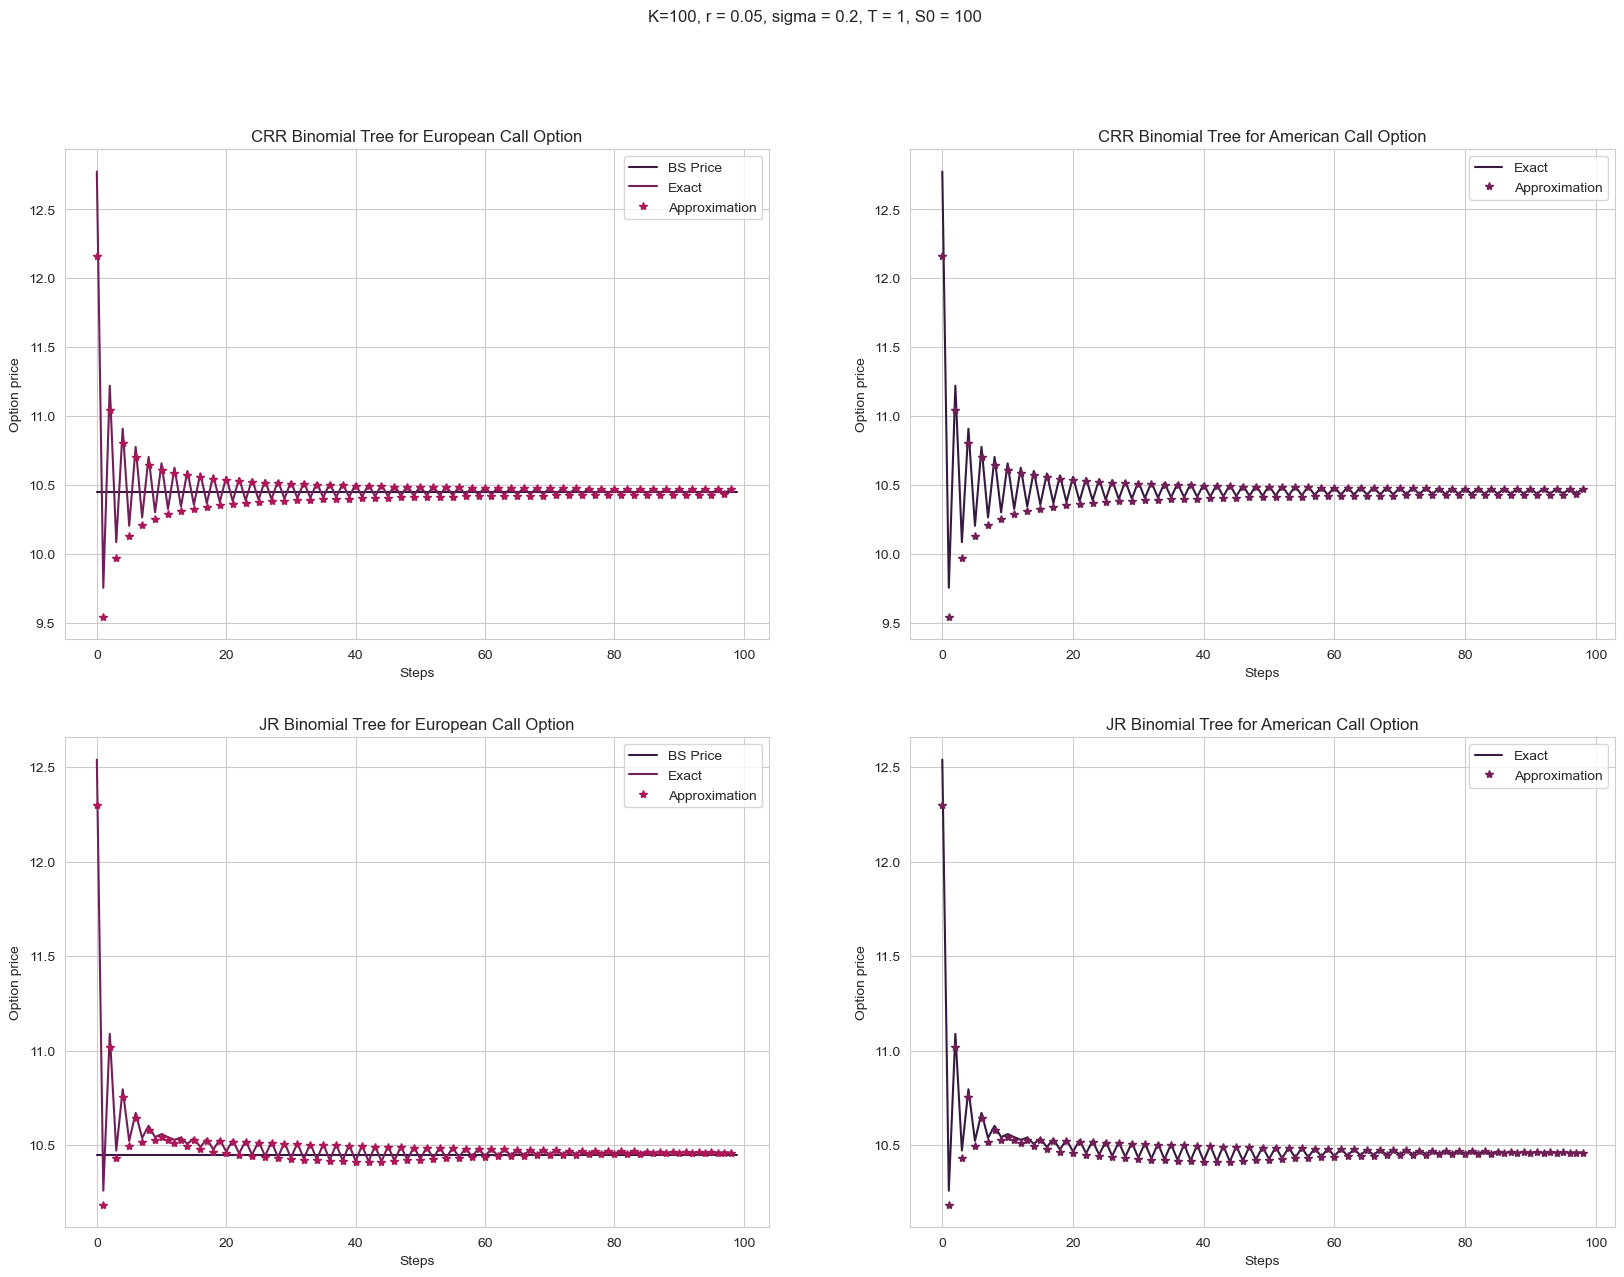

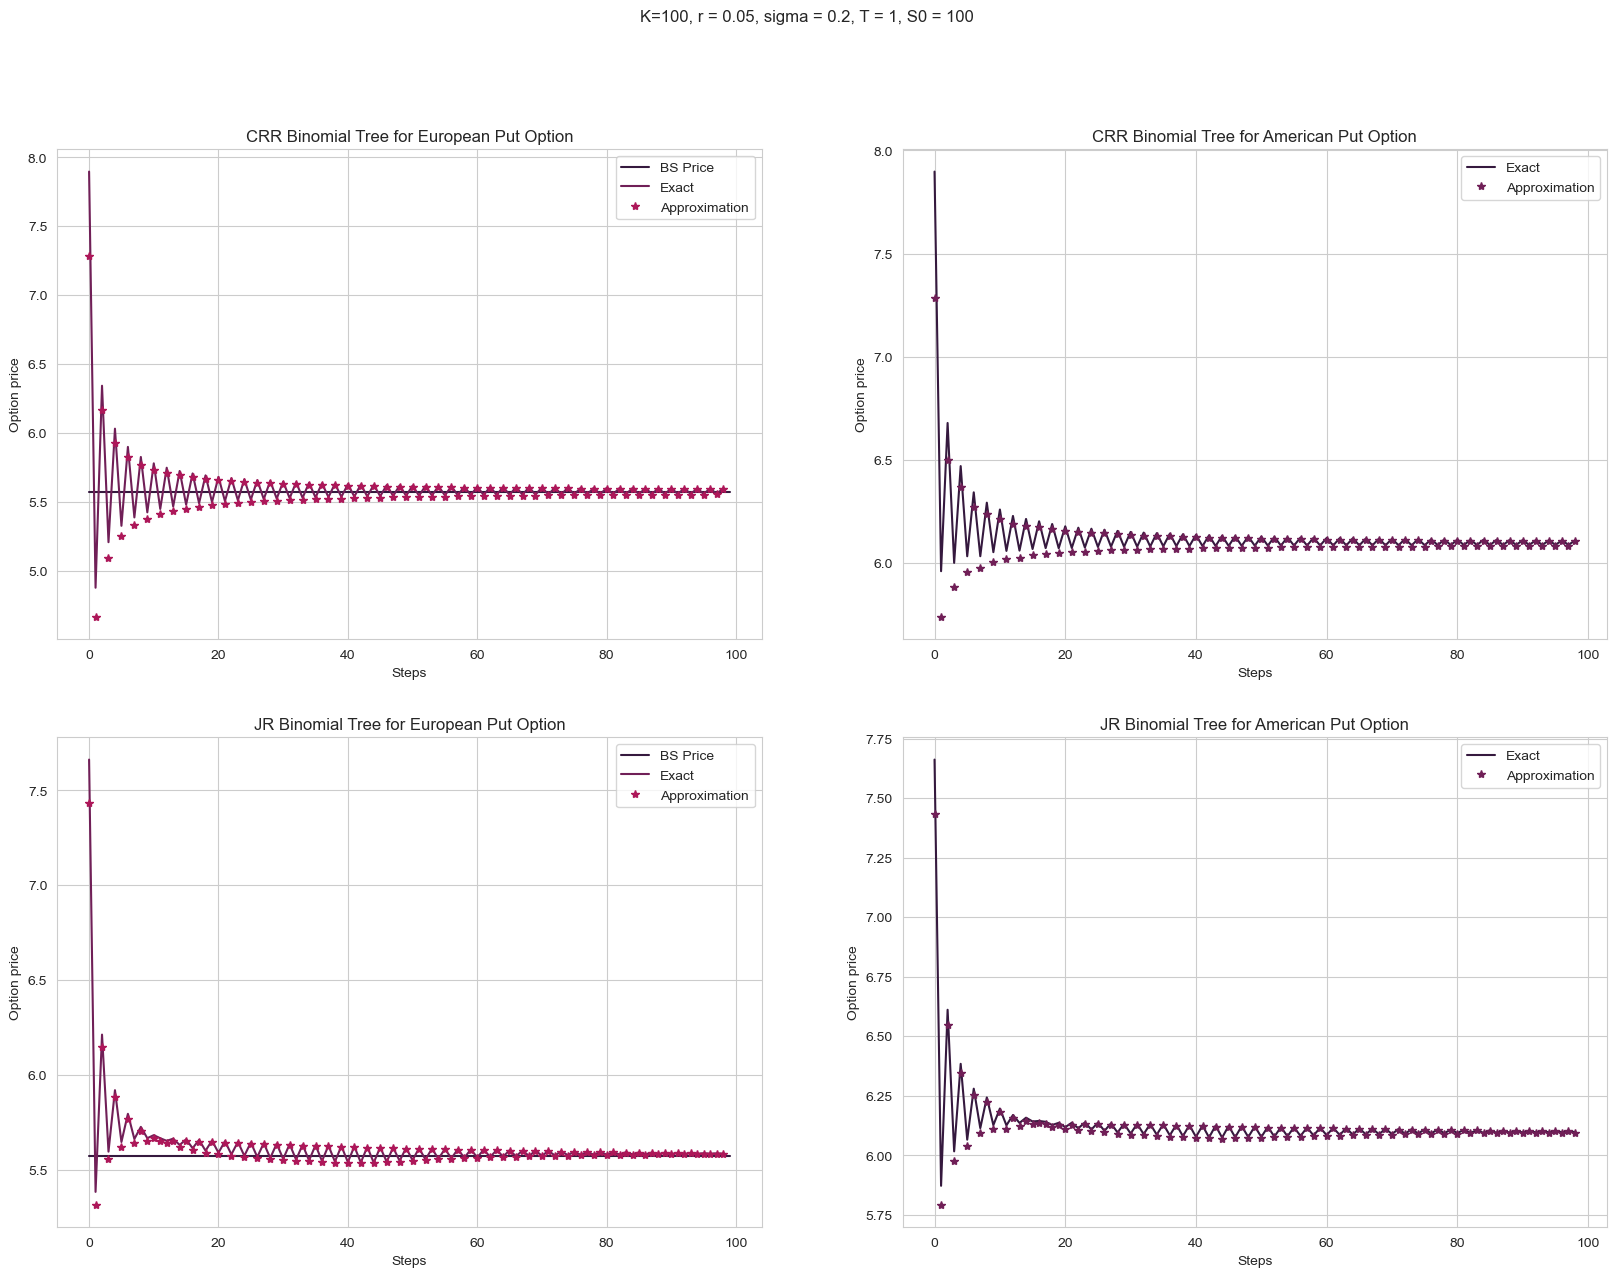

In [26]:
K = 100
r = 0.05
sigma = 0.2
T = 1
S = 100
N = 100

fig_call = Plot_European_American(K, r, sigma, T, N, S)
fig_call.show()

fig_put = Plot_European_American(K, r, sigma, T, N, S, call = False)
fig_put.show()

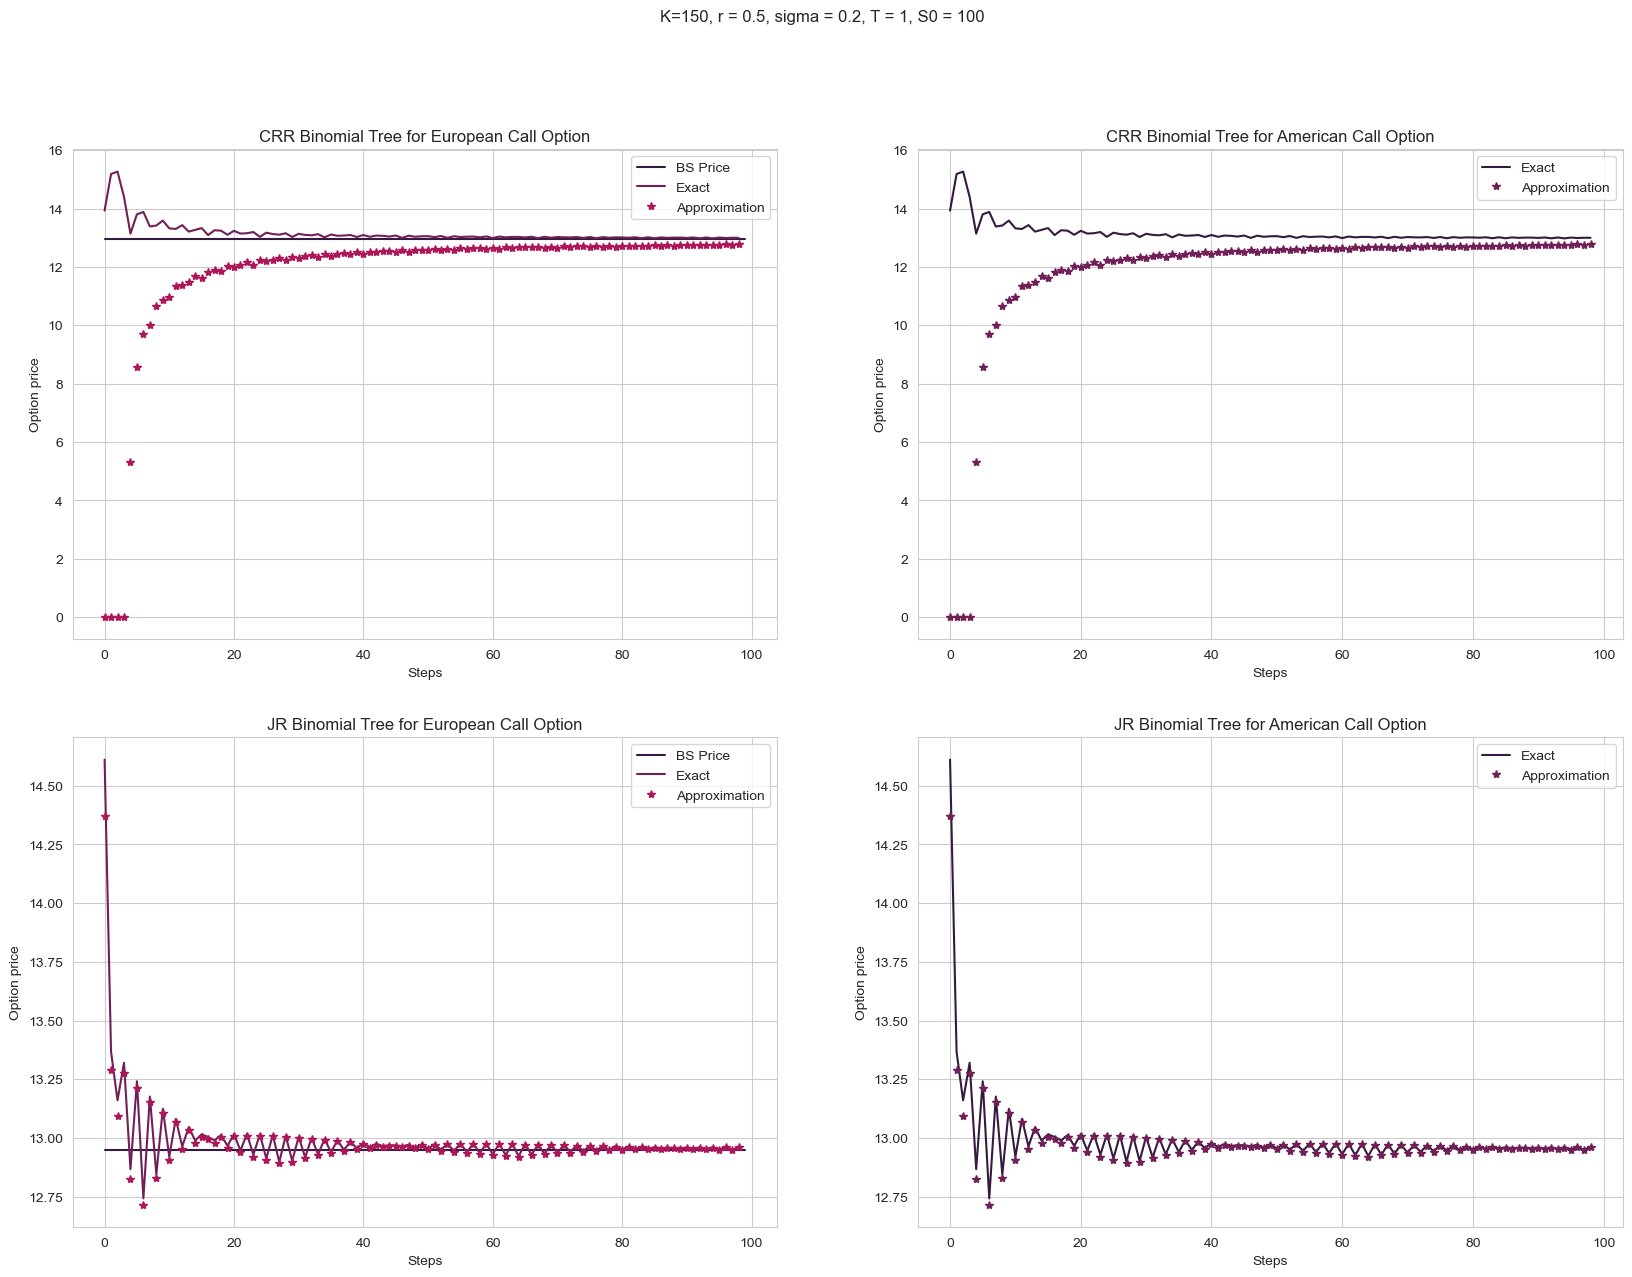

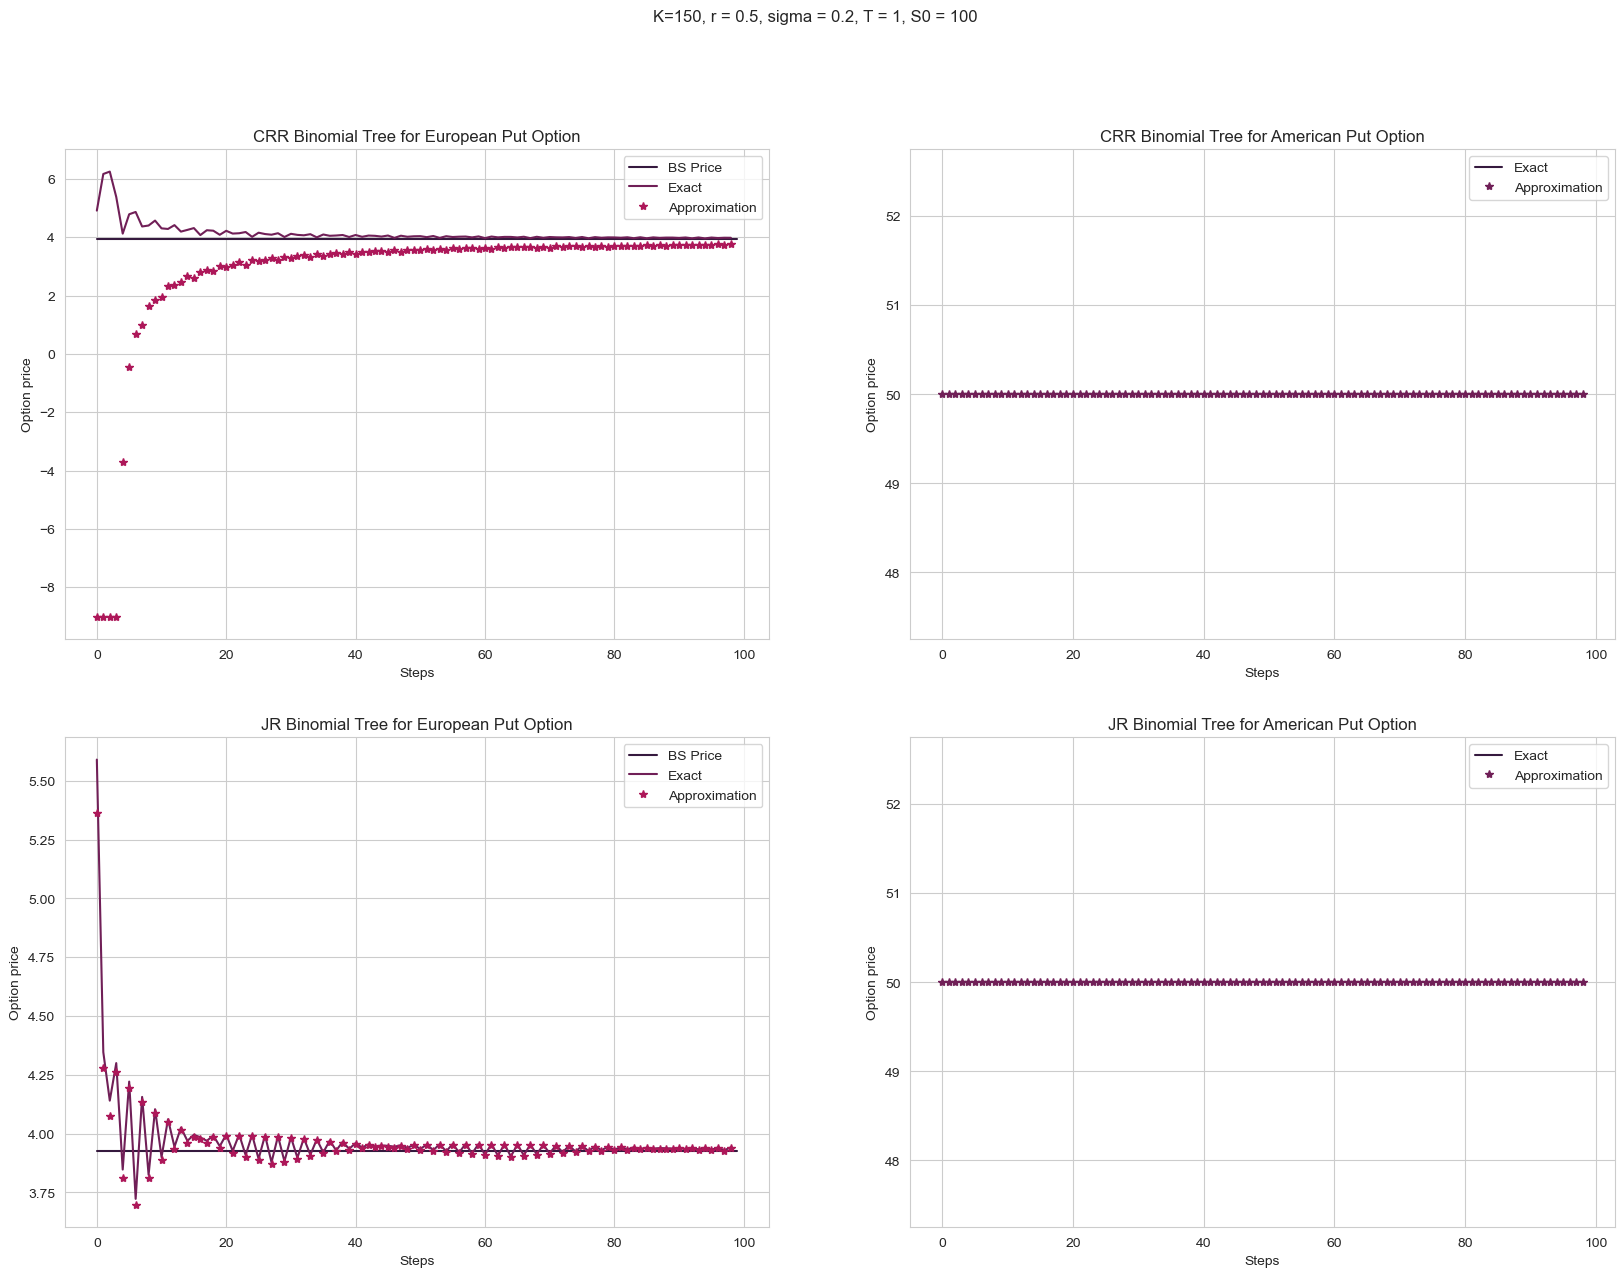

In [27]:
K = 150
r = 0.5
sigma = 0.2
T = 1
S = 100
N = 100

fig_call = Plot_European_American(K, r, sigma, T, N, S)
fig_call.show()

fig_put = Plot_European_American(K, r, sigma, T, N, S, call = False)
fig_put.show()

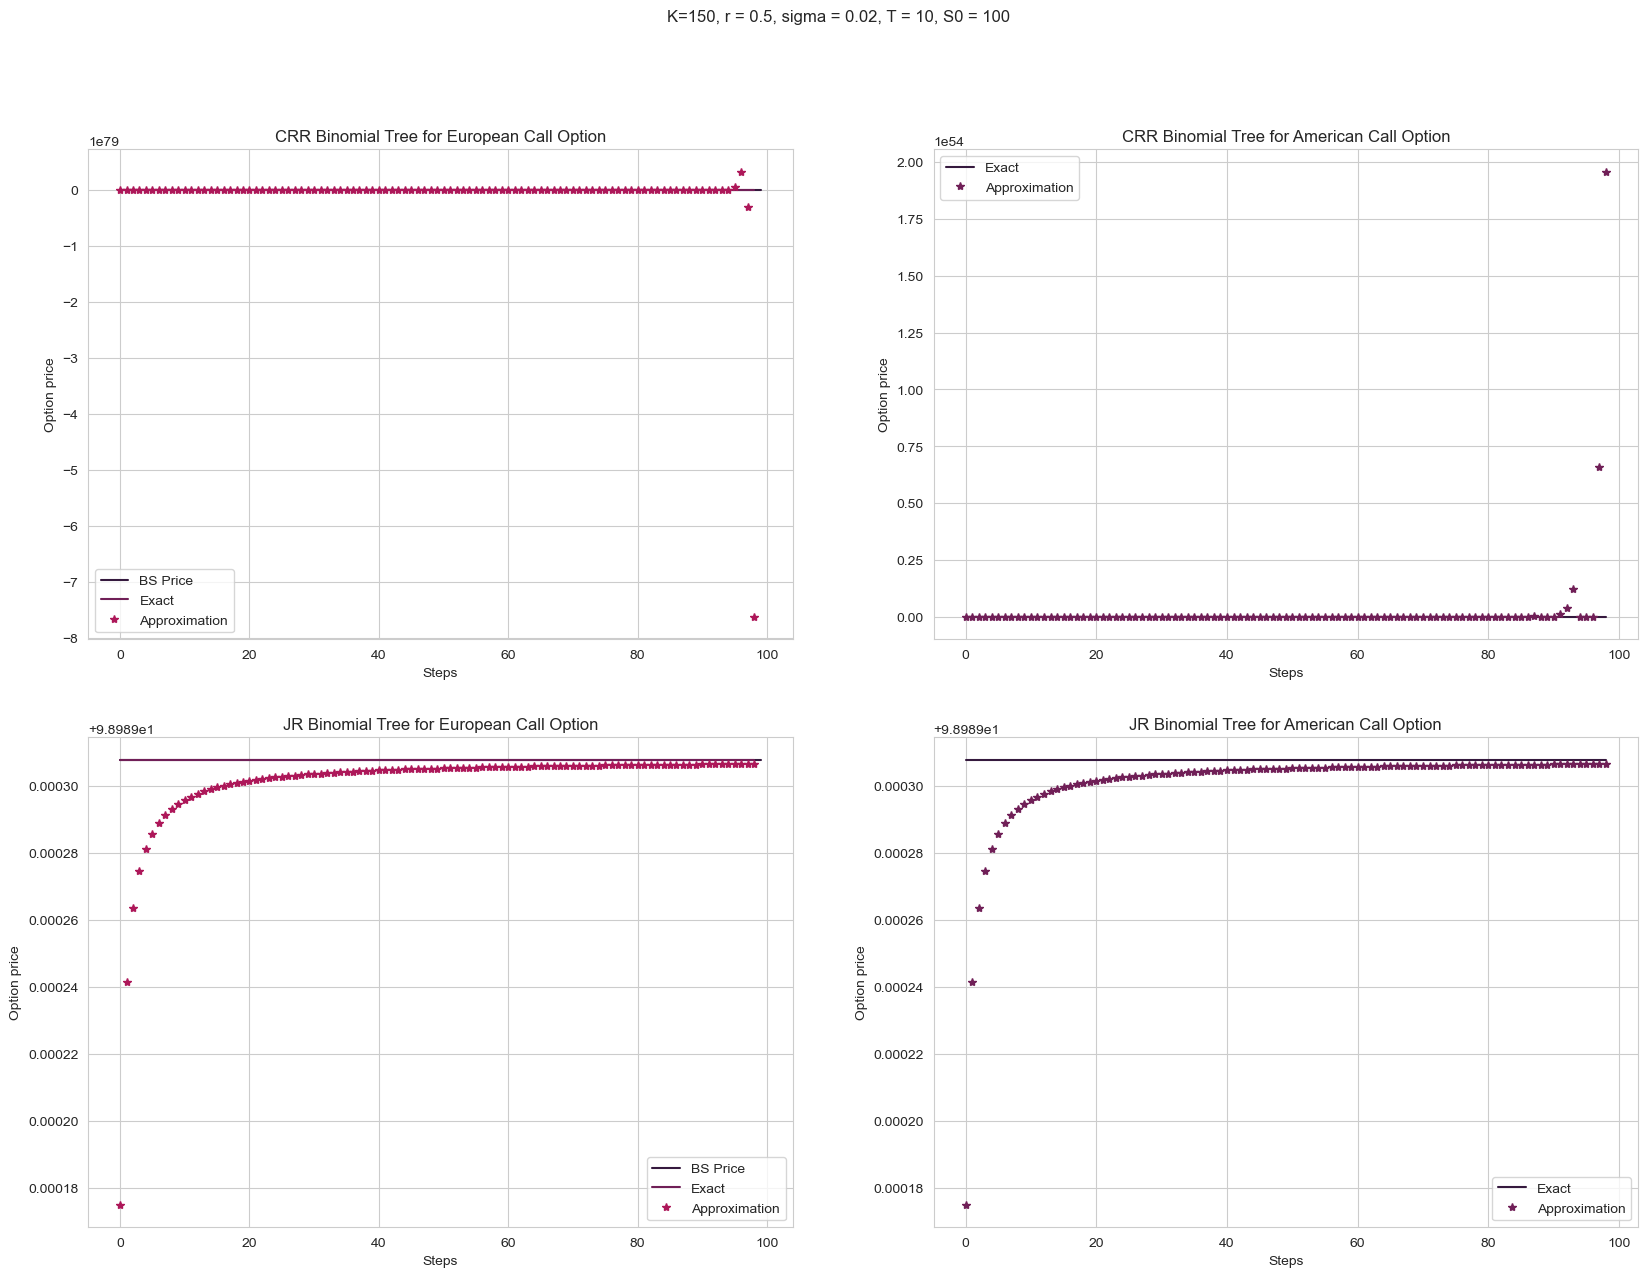

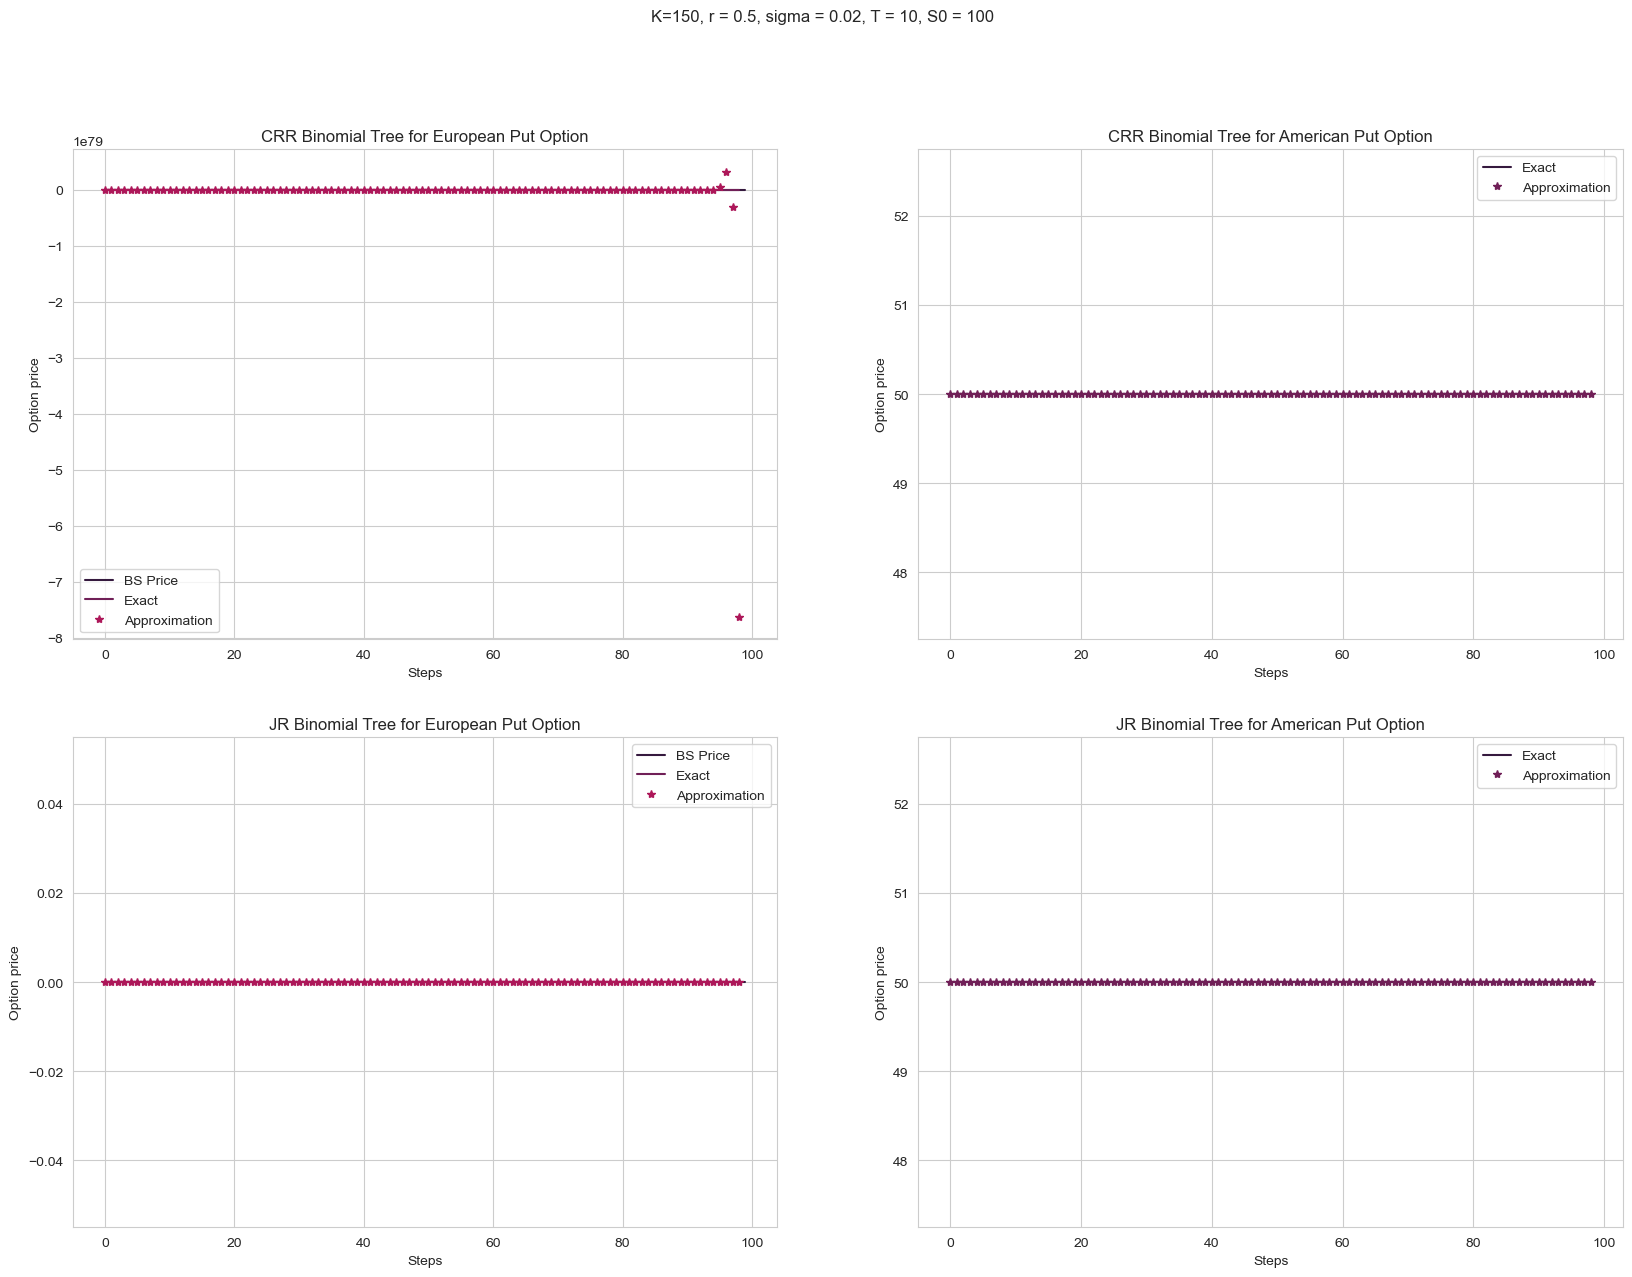

In [28]:
K = 150
r = 0.5
sigma = 0.02
T = 10
S = 100
N = 100

fig_call = Plot_European_American(K, r, sigma, T, N, S)
fig_call.show()

fig_put = Plot_European_American(K, r, sigma, T, N, S, call = False)
fig_put.show()

## European Options

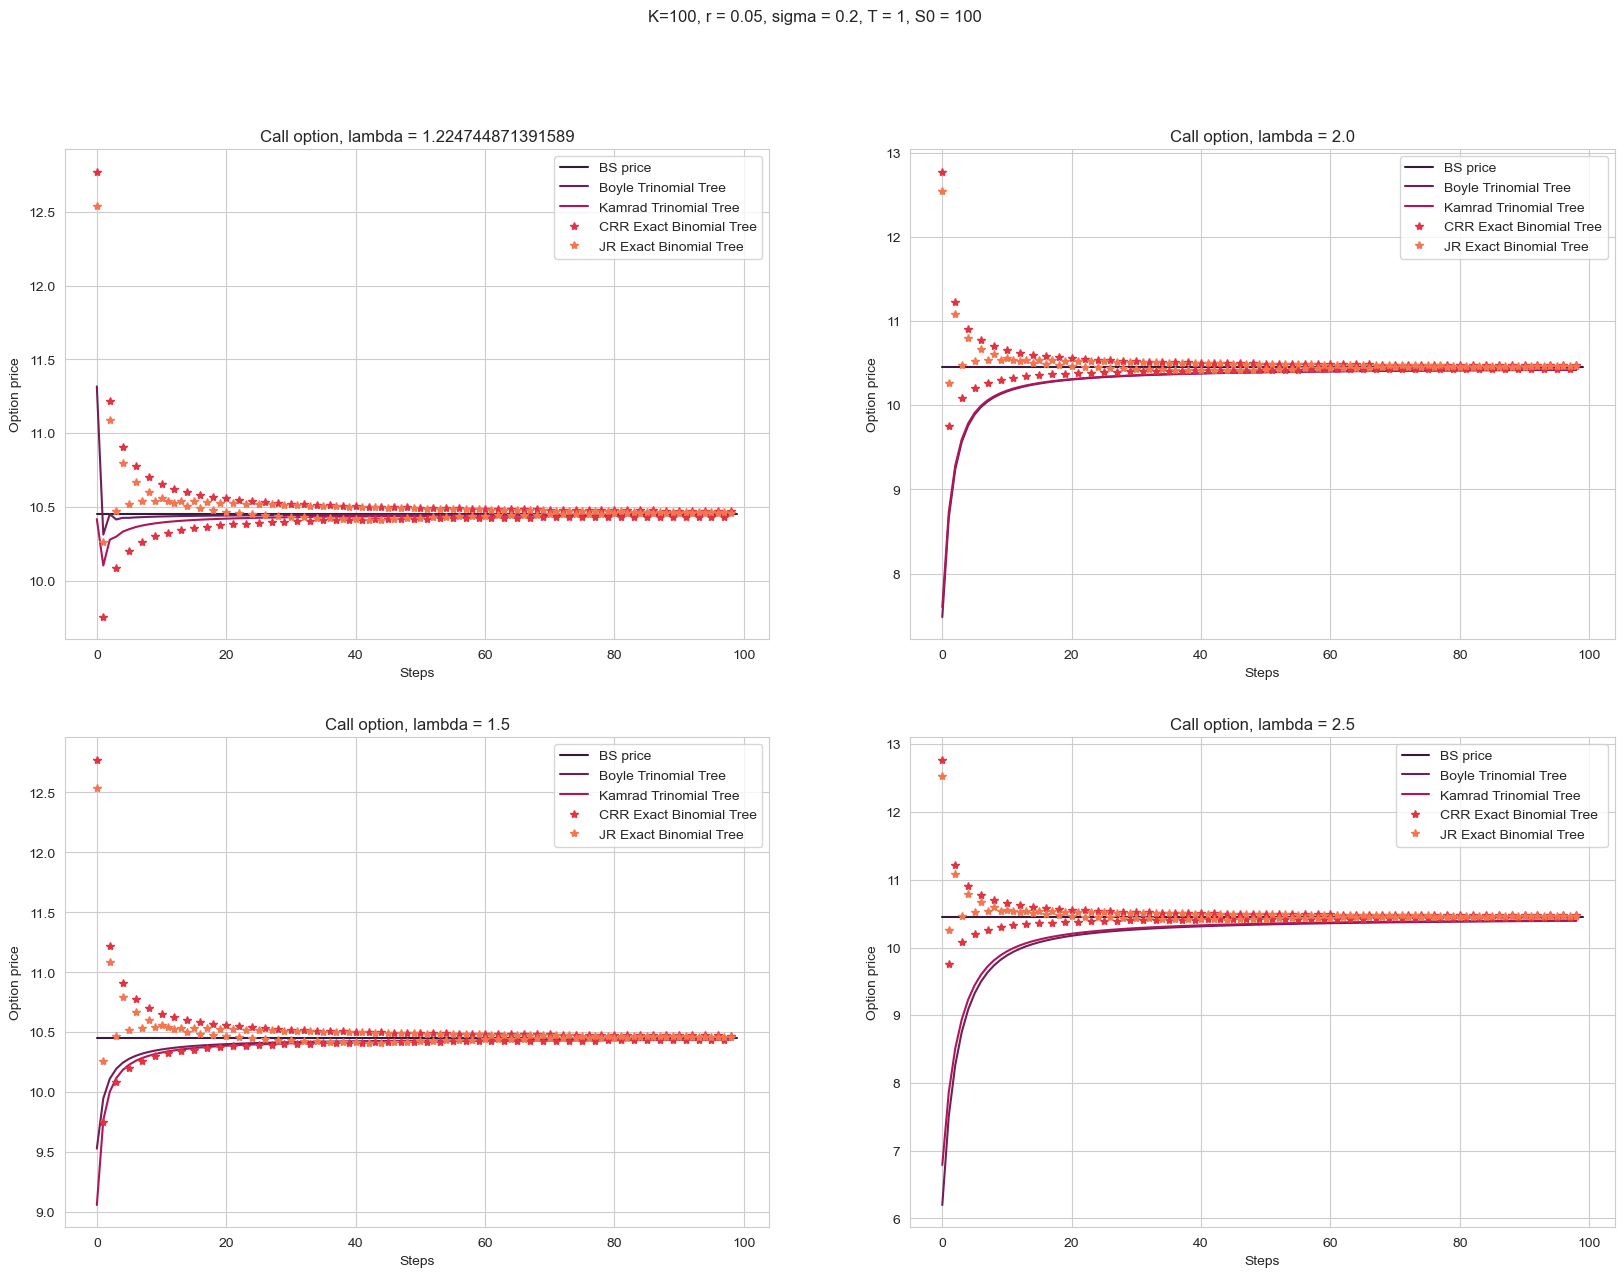

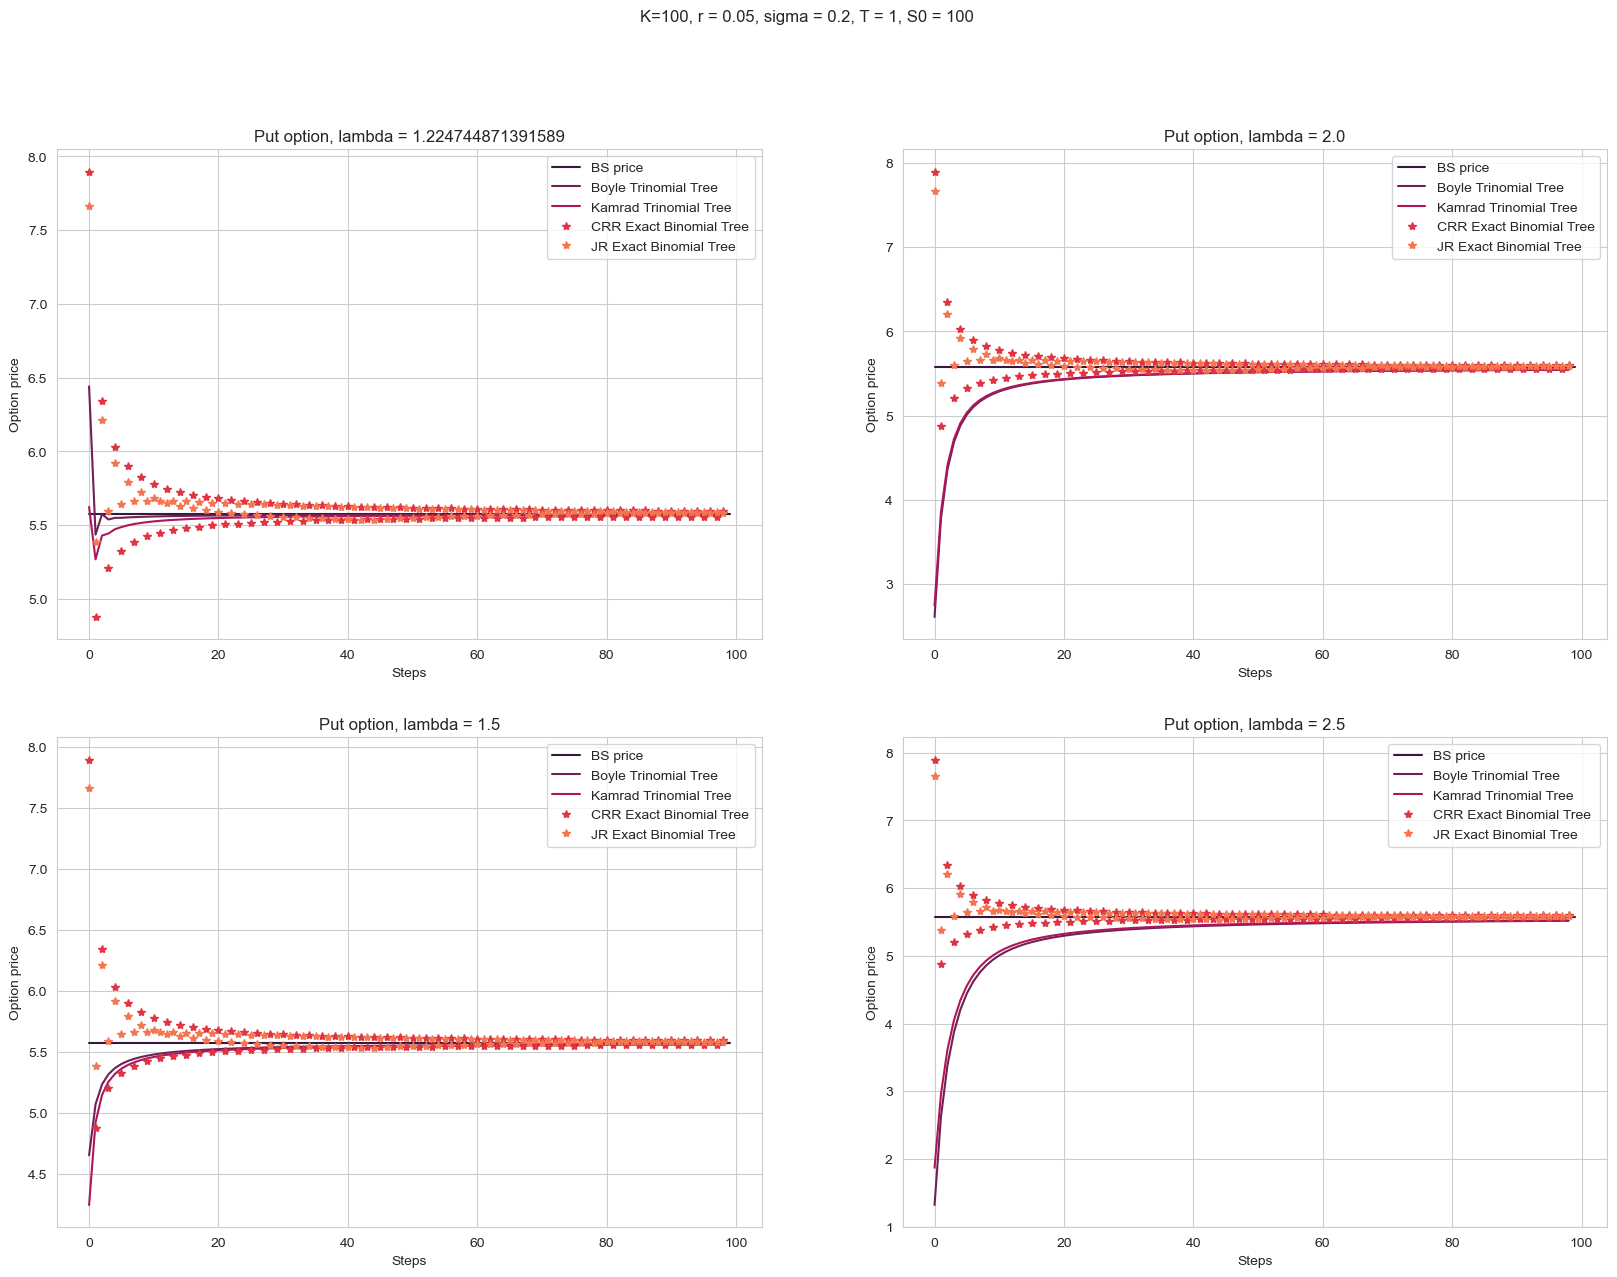

In [30]:
K = 100
r = 0.05
sigma = 0.2
T = 1
S = 100
N = 100
Lamb = [np.sqrt(3/2) , 1.5 , 2.0 , 2.5]

fig_call = Plot_Trinomial_European(K, r, sigma, Lamb, T, N, S)
fig_call.show()

fig_put = Plot_Trinomial_European(K, r, sigma, Lamb, T, N, S, call = False)
fig_put.show()

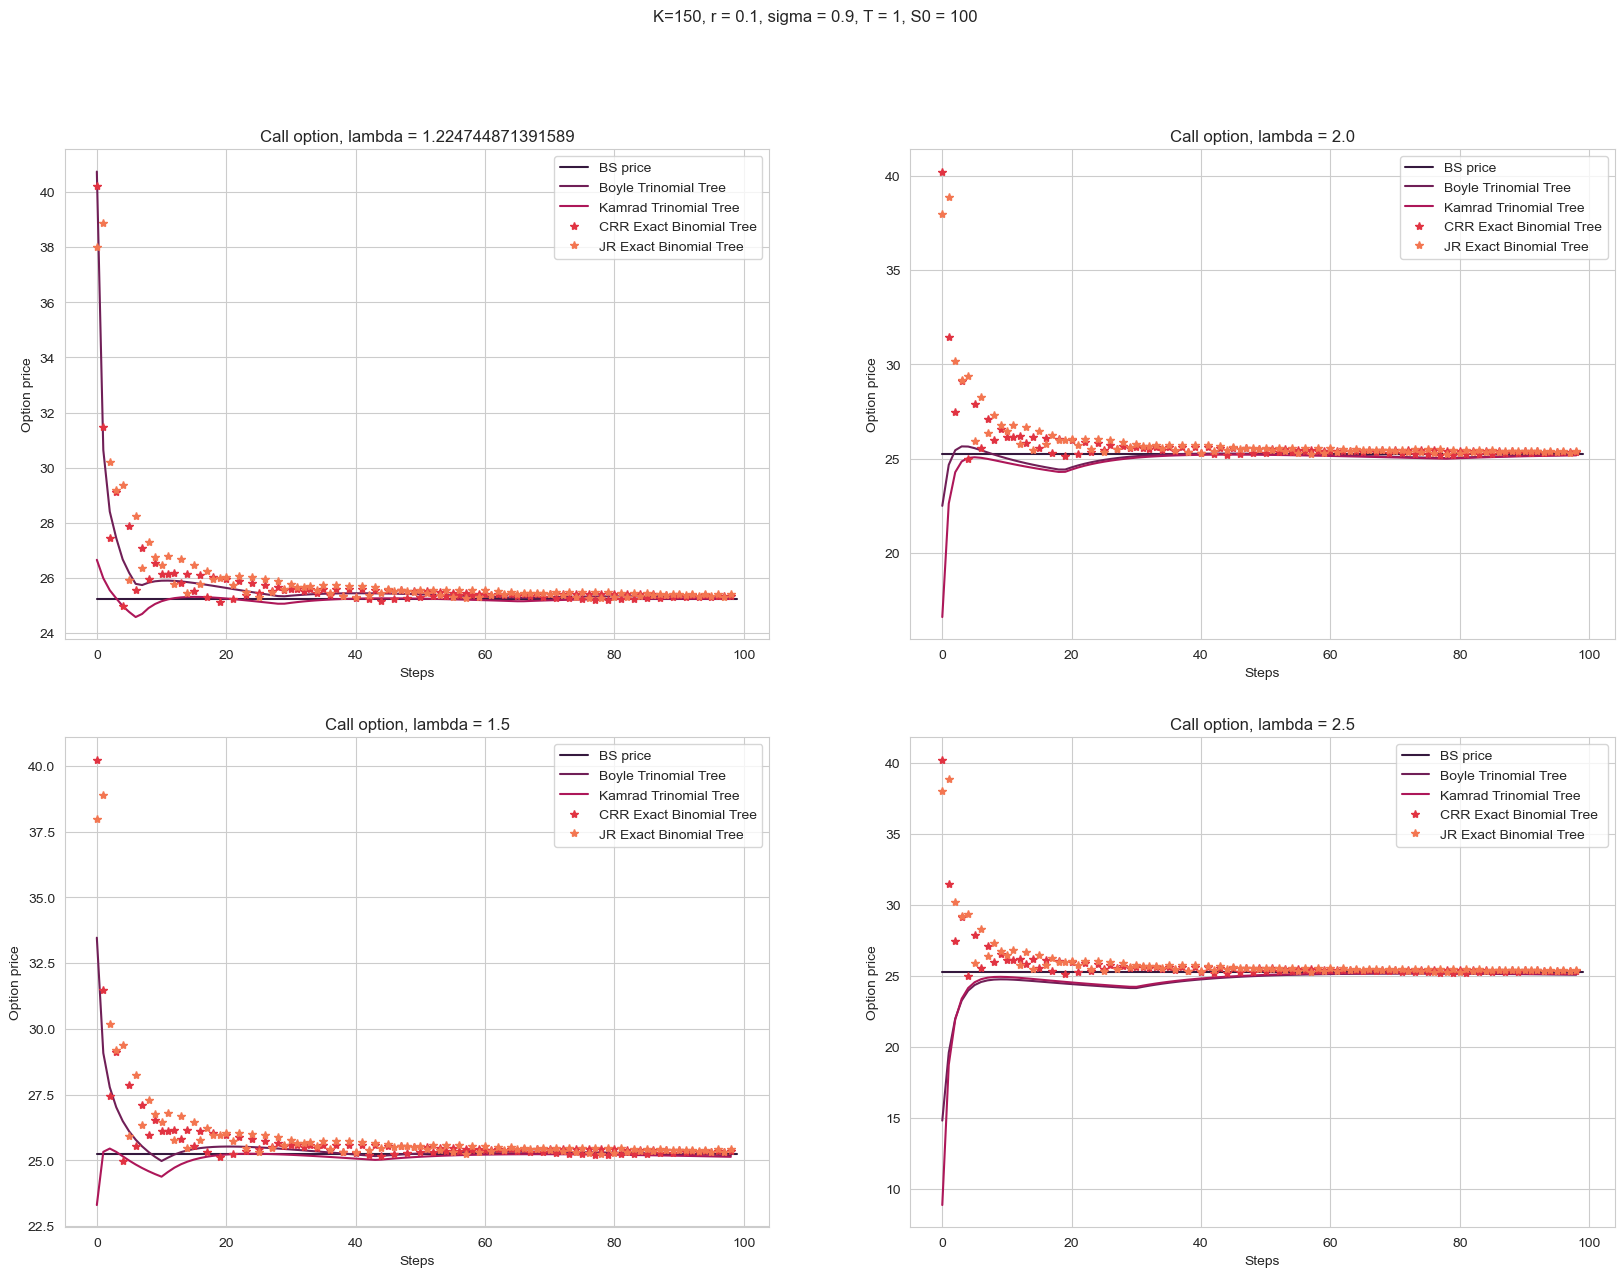

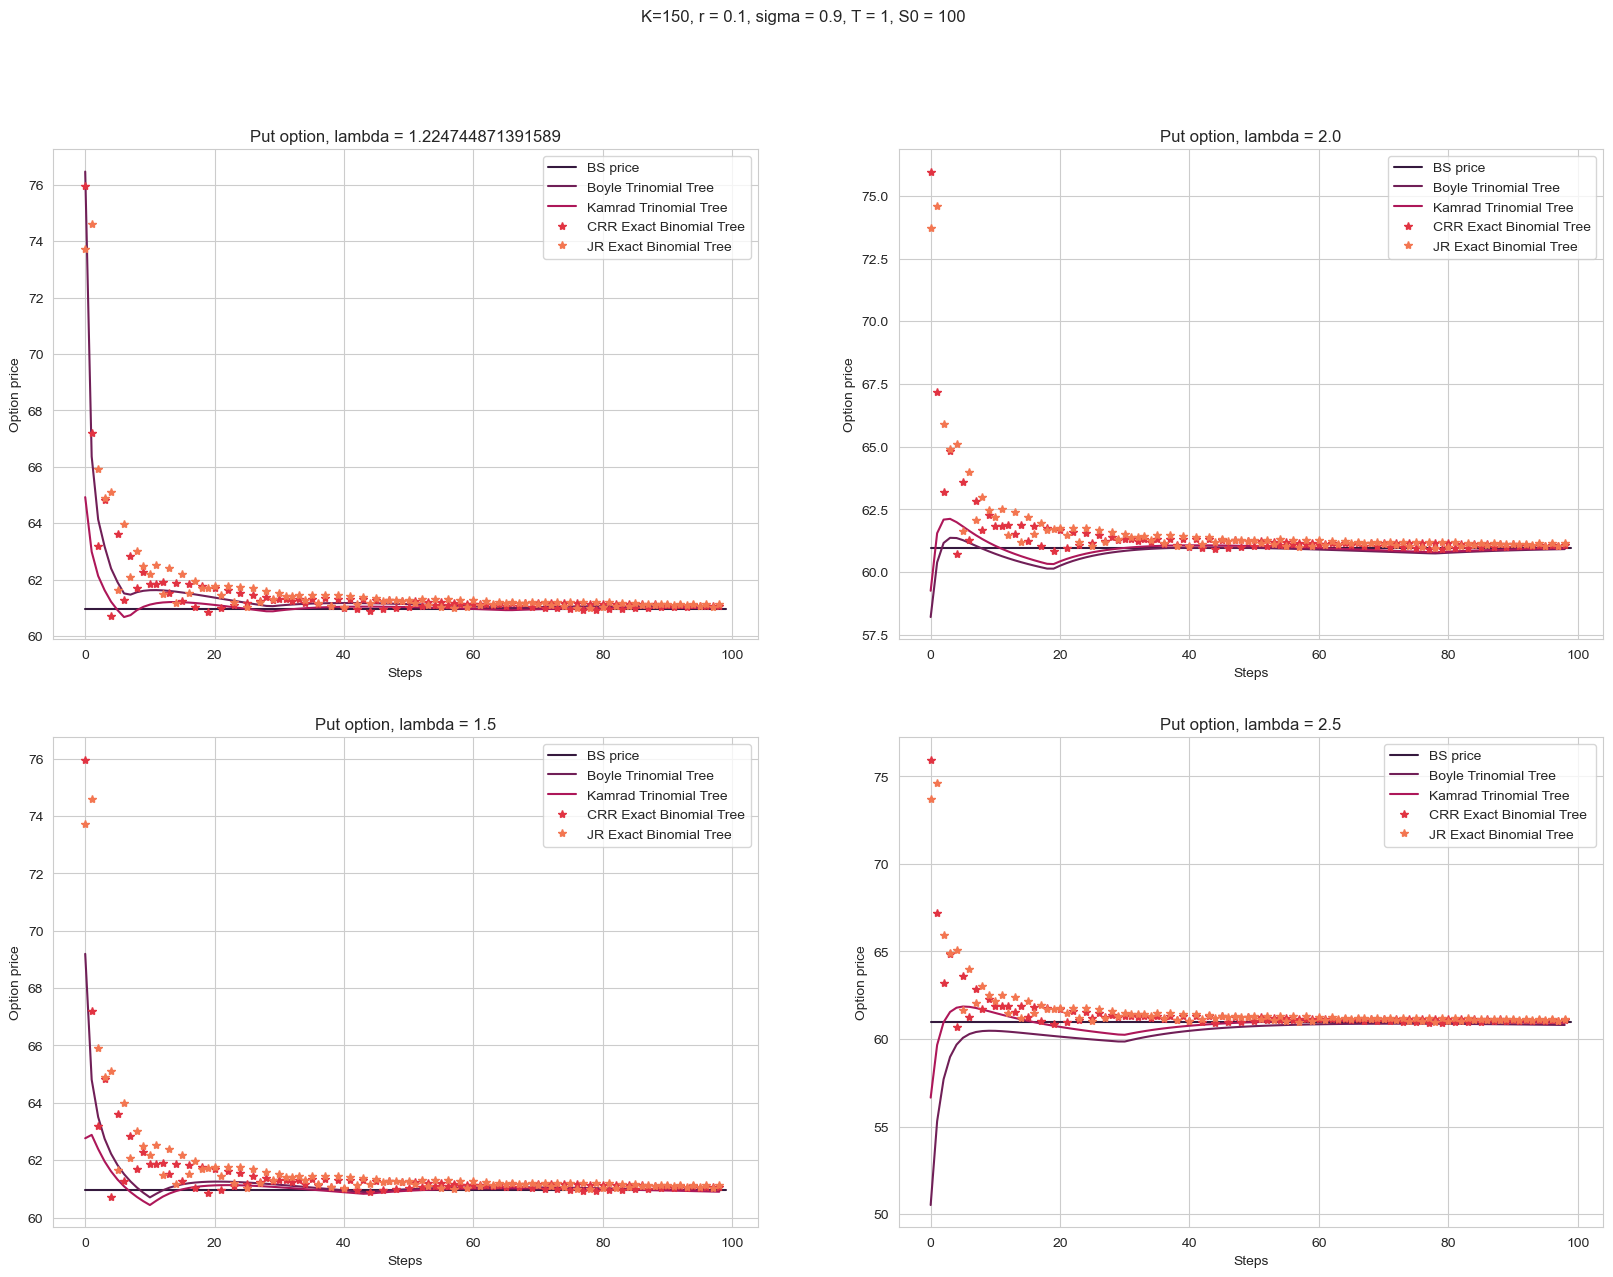

In [29]:
K = 150
r = 0.1
sigma = 0.9
T = 1
S = 100
N = 100
Lamb = [np.sqrt(3/2) , 1.5 , 2.0 , 2.5]

fig_call = Plot_Trinomial_European(K, r, sigma, Lamb, T, N, S)
fig_call.show()

fig_put = Plot_Trinomial_European(K, r, sigma, Lamb, T, N, S, call = False)
fig_put.show()

## American Options 

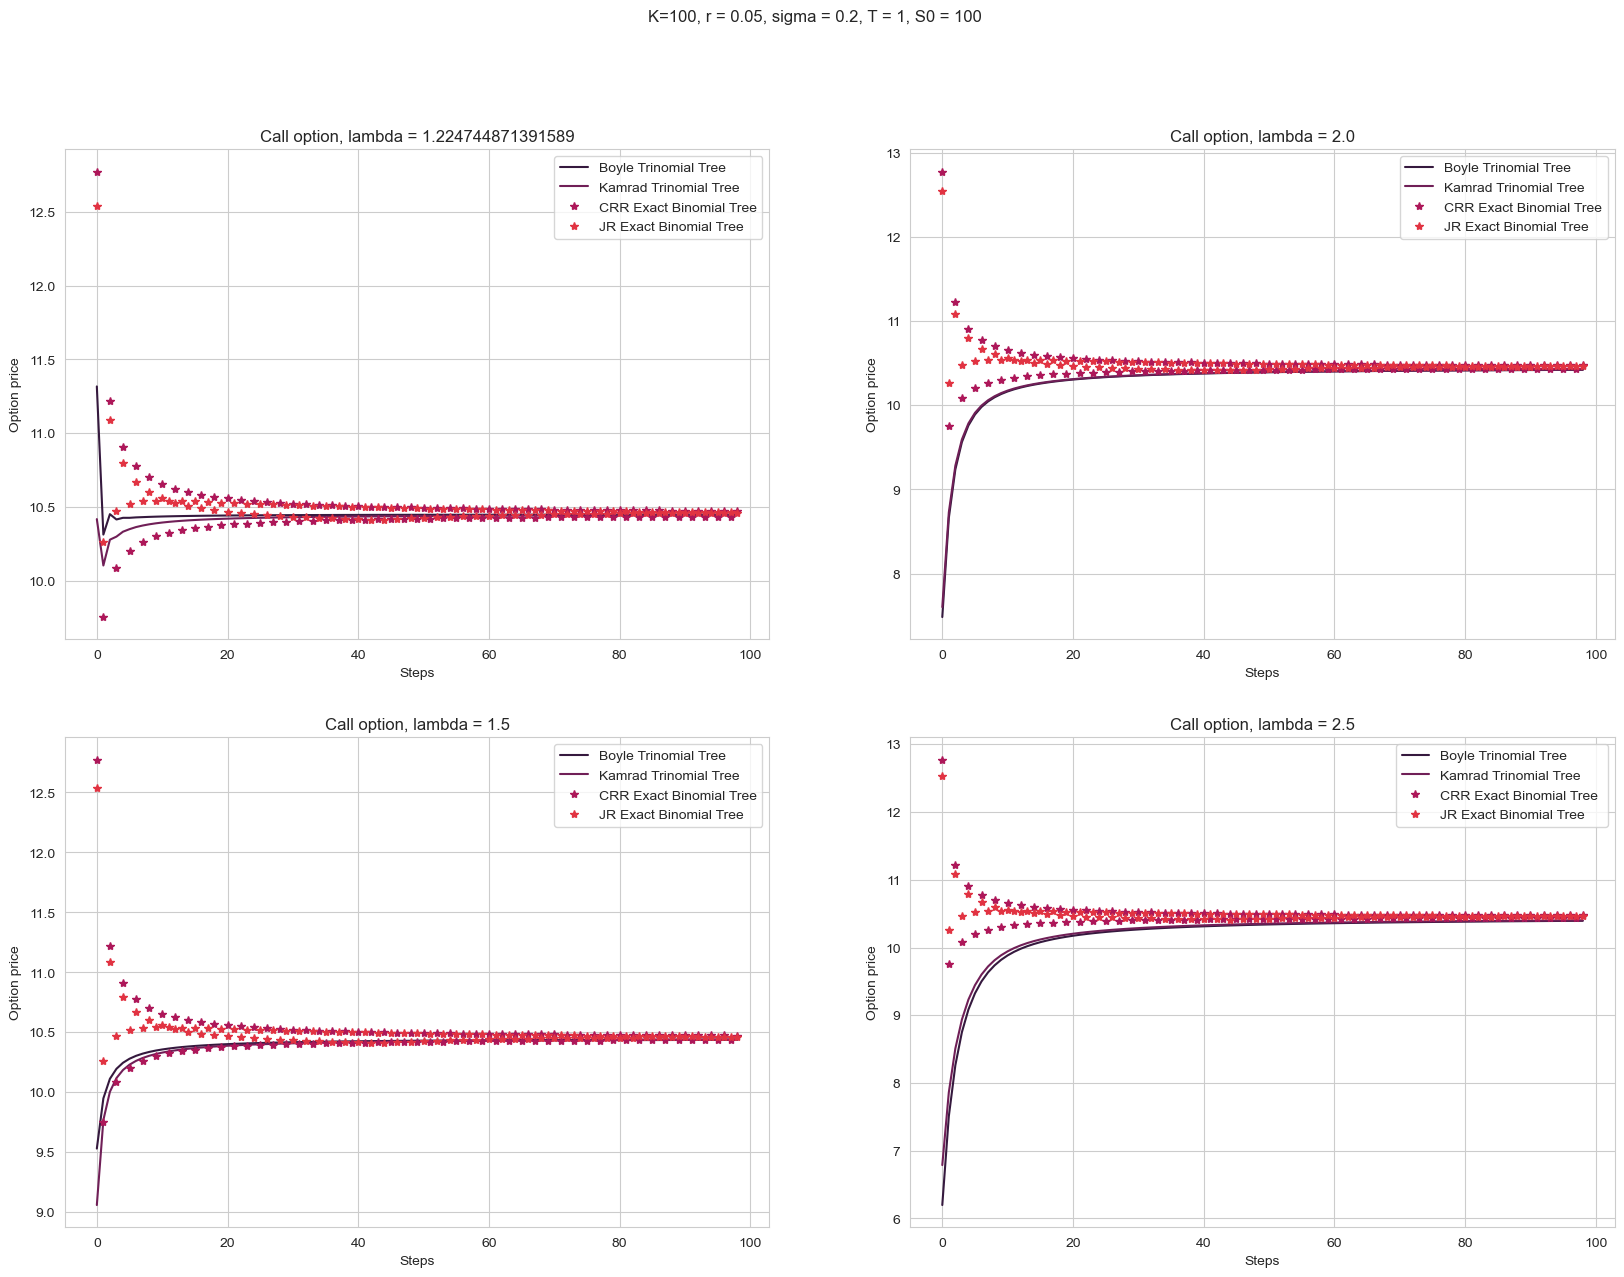

In [31]:
K = 100
r = 0.05
sigma = 0.2
T = 1
S = 100
N = 100
Lamb = [np.sqrt(3/2) , 1.5 , 2.0 , 2.5]

fig = Plot_Trinomial_American(K, r, sigma, Lamb, T, N, S)

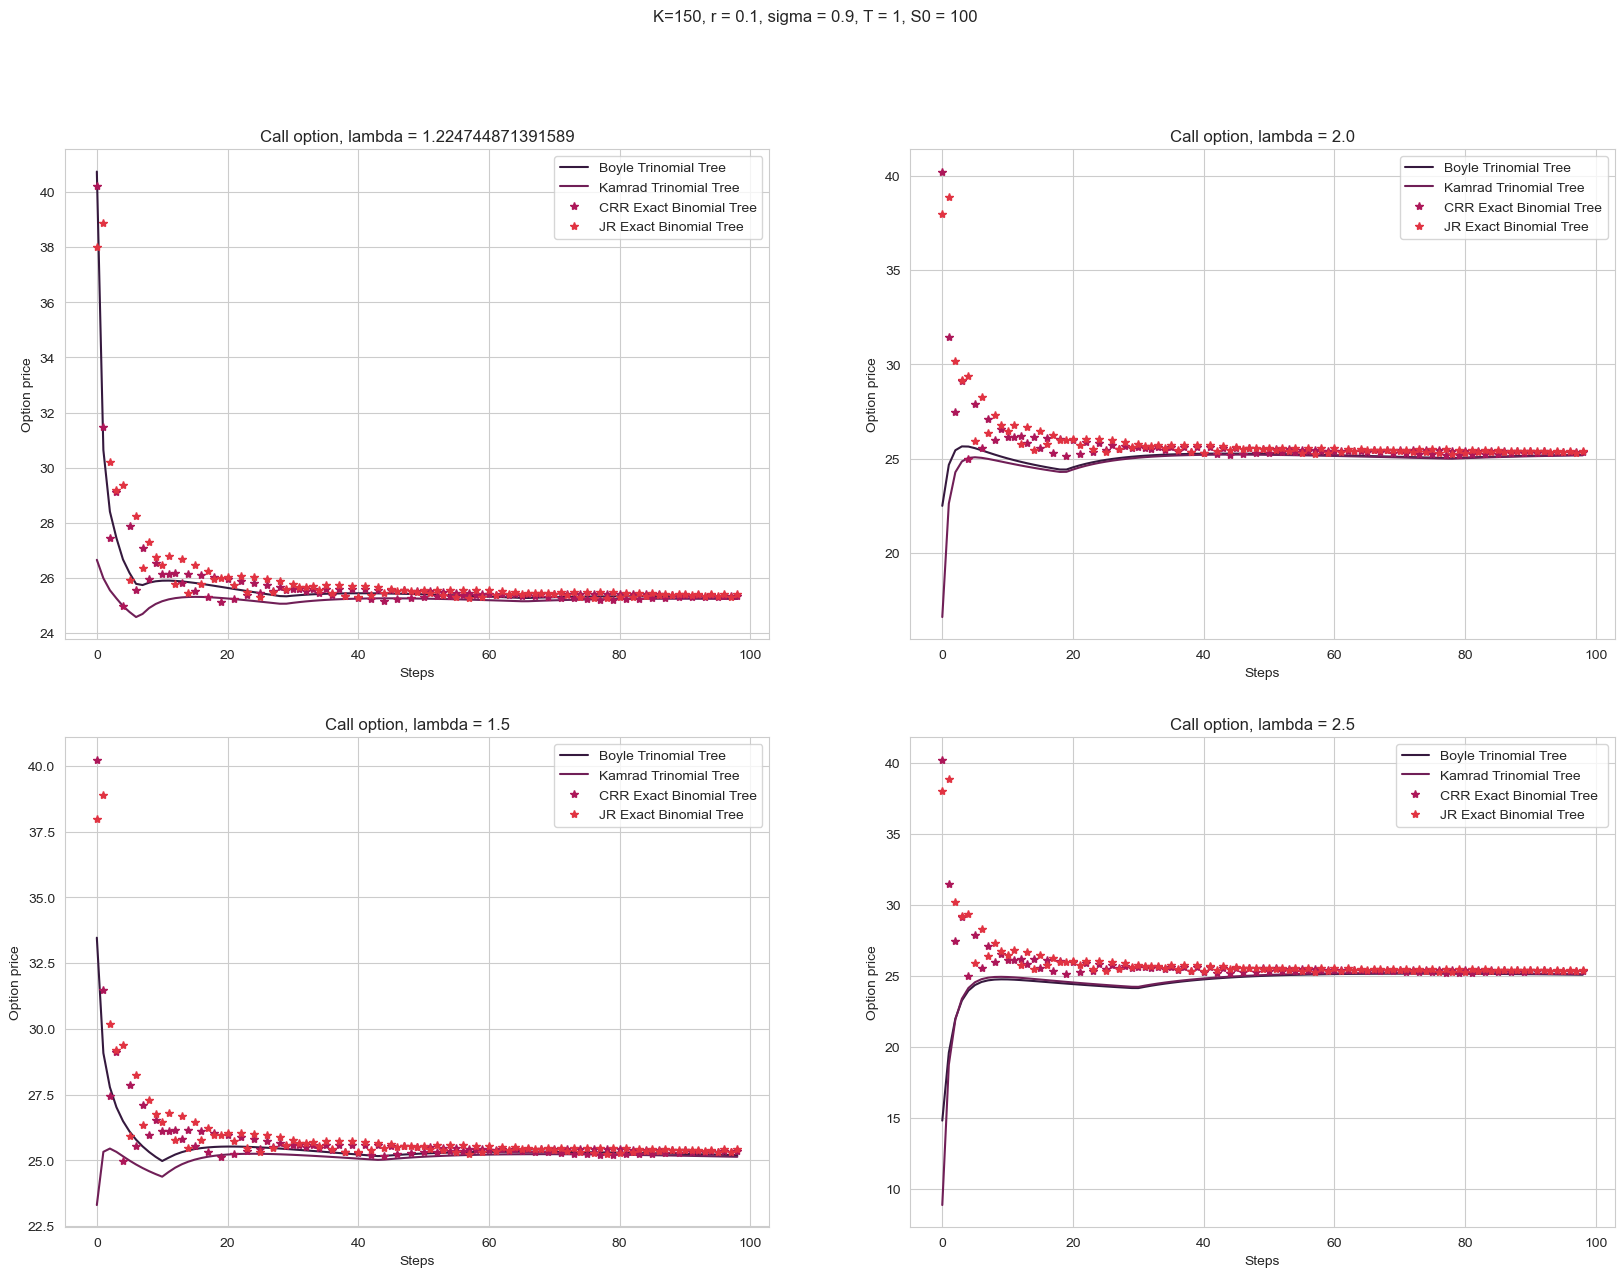

In [32]:
K = 150
r = 0.1
sigma = 0.9
T = 1
S = 100
N = 100
Lamb = [np.sqrt(3/2) , 1.5 , 2.0 , 2.5]

fig = Plot_Trinomial_American(K, r, sigma, Lamb, T, N, S)

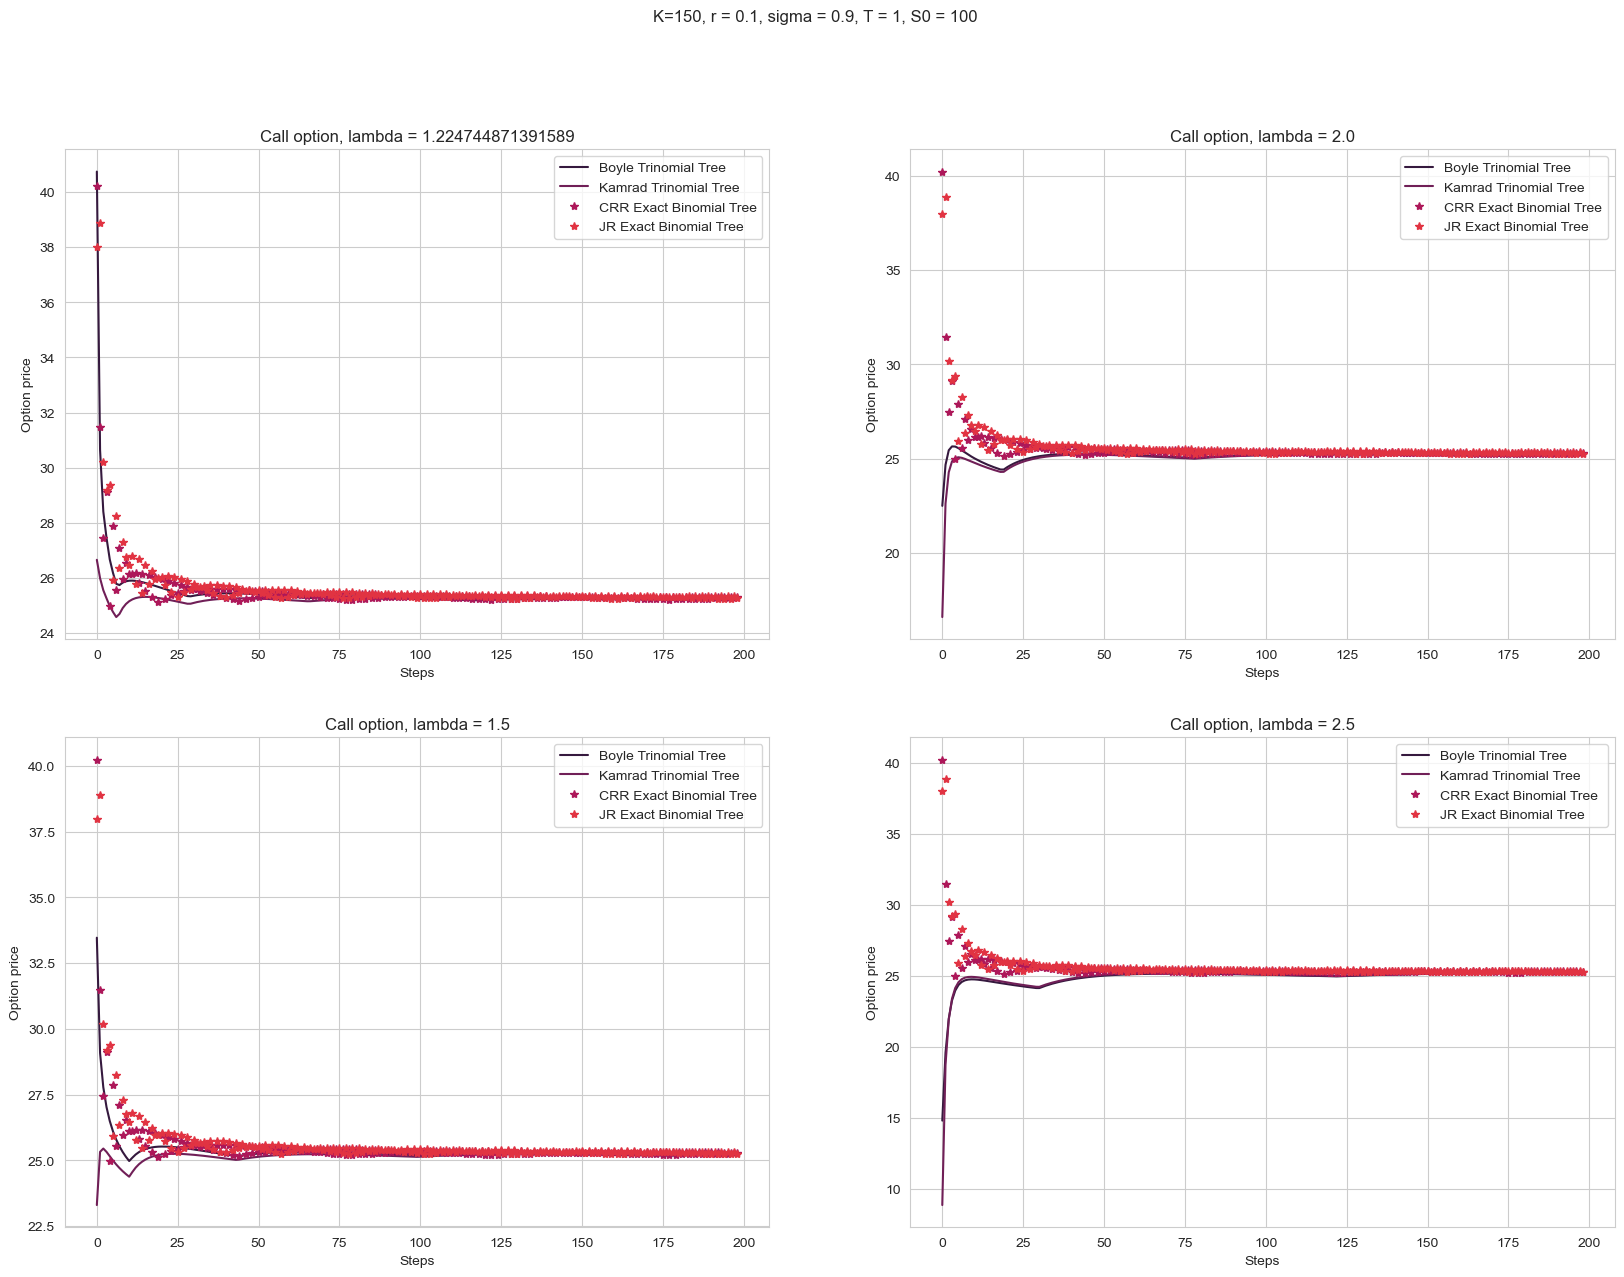

In [33]:
K = 150
r = 0.1
sigma = 0.9
T = 1
S = 100
N = 200
Lamb = [np.sqrt(3/2), 1.5, 2.0, 2.5]

fig = Plot_Trinomial_American(K, r, sigma, Lamb, T, N, S)